In [ ]:
"""
@author Anthony Martin
@email am@cadenzai.net

Fixed Implementation of RKDO vs I-Con Benchmark for Notebooks
===========================================================

This implementation resolves the tensor transformation issue and provides
a cleaner comparison between the frameworks.
"""

import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image


# Data utilities
def get_datasets(dataset_name):
    """
    Load standard datasets for benchmarking.
    """
    # Base transform for test set
    base_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Create augmentation transform for contrastive learning
    augment_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # For STL-10, we need to use slightly different transforms due to larger images
    stl10_base_transform = transforms.Compose([
        transforms.Resize(64),  # Resize to 64x64 instead of 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    stl10_augment_transform = transforms.Compose([
        transforms.Resize(64),
        transforms.RandomResizedCrop(64, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(
            root="./data", train=True, download=True, transform=None
        )
        test_dataset = datasets.CIFAR10(
            root="./data", train=False, download=True, transform=base_transform
        )
        return train_dataset, test_dataset, augment_transform

    elif dataset_name == "cifar100":
        train_dataset = datasets.CIFAR100(
            root="./data", train=True, download=True, transform=None
        )
        test_dataset = datasets.CIFAR100(
            root="./data", train=False, download=True, transform=base_transform
        )
        return train_dataset, test_dataset, augment_transform

    elif dataset_name == "stl10":
        train_dataset = datasets.STL10(
            root="./data", split="train", download=True, transform=None
        )
        test_dataset = datasets.STL10(
            root="./data", split="test", download=True, transform=stl10_base_transform
        )
        return train_dataset, test_dataset, stl10_augment_transform

    else:
        raise ValueError(f"Dataset {dataset_name} not supported")


# Configuration
class Config:
    def __init__(self, dataset_name="cifar10"):
        # General settings
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Adjust batch size based on dataset (STL-10 has larger images)
        if dataset_name == "stl10":
            self.batch_size = 32  # Smaller batch for larger images
        else:
            self.batch_size = 64

        self.num_epochs = 10
        self.lr = 0.001
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5

        # Framework-specific settings
        # RKDO settings
        self.rkdo_recursion_depth = 3
        self.rkdo_coupling_strength = 0.5

        # I-Con settings
        self.icon_p_distribution = "gaussian"
        self.icon_q_distribution = "gaussian"
        self.icon_debias_alpha = 0.2

# Modified contrastive dataset that correctly handles transformations
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # Convert tensor back to PIL Image if needed
        if isinstance(img, torch.Tensor):
            # Convert to PIL Image for transformation
            img = transforms.ToPILImage()(img)

        # Apply two different augmentations
        view1 = self.transform(img)
        view2 = self.transform(img)
        return view1, view2, label

    def __len__(self):
        return len(self.dataset)


# Neural network architectures
class EncoderNetwork(nn.Module):
    def __init__(self, model_name="resnet18", embedding_dim=128):
        super(EncoderNetwork, self).__init__()

        # Use a smaller model for notebooks
        self.backbone = models.resnet18(weights=None)  # No pre-training for fair comparison
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.ReLU(),
            nn.Linear(self.feature_dim, embedding_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.projection(features)
        # Normalize embeddings to unit sphere
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

# Framework implementations
class RKDO:
    """
    Implementation of the Recursive Divergence Fields framework.
    """
    def __init__(self, config):
        self.config = config
        self.recursion_depth = config.rkdo_recursion_depth
        self.coupling_strength = config.rkdo_coupling_strength
        self.device = config.device
        self.temperature = config.temperature

    def compute_loss(self, embeddings_1, embeddings_2):
        """
        Compute the RKDO loss over recursively defined distributions.
        """
        batch_size = embeddings_1.shape[0]

        # Initial distribution (p^(0))
        p_0 = torch.zeros(batch_size, batch_size).to(self.device)
        # Set diagonal to 1 (positive pairs)
        p_0.fill_diagonal_(1.0)

        # Initial distribution (q^(0))
        # Calculate pairwise similarities
        sim_matrix = torch.mm(embeddings_1, embeddings_2.t())
        # Apply temperature scaling
        sim_matrix = sim_matrix / self.temperature
        # Apply softmax to get probability distribution
        q_0 = F.softmax(sim_matrix, dim=1)

        # Recursively update distributions
        p_t = p_0
        q_t = q_0

        # Store losses at each iteration
        losses = []

        for t in range(1, self.recursion_depth + 1):
            # Update p^(t) based on q^(t-1)
            p_t = self._update_p(q_t, p_t)

            # Update q^(t) based on current embeddings
            q_t = self._update_q(embeddings_1, embeddings_2, t)

            # Compute KL divergence at current iteration
            loss_t = 0
            for i in range(batch_size):
                # Add small epsilon to prevent log(0)
                epsilon = 1e-8
                # Compute KL divergence: DKL(p^(t)(·|i) || q^(t)(·|i))
                loss_i = torch.sum(p_t[i] * torch.log((p_t[i] + epsilon) / (q_t[i] + epsilon)))
                loss_t += loss_i

            # Normalize by batch size
            loss_t = loss_t / batch_size
            losses.append(loss_t)

        # Final loss is the sum of losses at each iteration
        final_loss = sum(losses)
        return final_loss

    def _update_p(self, q_prev, p_prev):
        """
        Update target distribution p^(t) based on previous q^(t-1)
        """
        # Implement FP function: Linear interpolation between initial p and previous q
        p_new = (1 - self.coupling_strength) * p_prev + self.coupling_strength * q_prev
        return p_new

    def _update_q(self, embeddings_1, embeddings_2, t):
        """
        Update learned distribution q^(t) based on current embeddings
        """
        batch_size = embeddings_1.shape[0]

        # Calculate pairwise similarities
        sim_matrix = torch.mm(embeddings_1, embeddings_2.t())

        # Apply time-dependent temperature scaling
        temp_t = self.temperature * (1 - 0.1 * (t / self.recursion_depth))
        sim_matrix = sim_matrix / temp_t

        # Apply softmax to get probability distribution
        q_new = F.softmax(sim_matrix, dim=1)

        return q_new

class ICon:
    """
    Implementation of the I-Con framework.
    """
    def __init__(self, config):
        self.config = config
        self.device = config.device
        self.p_distribution = config.icon_p_distribution
        self.q_distribution = config.icon_q_distribution
        self.debias_alpha = config.icon_debias_alpha
        self.temperature = config.temperature

    def compute_loss(self, embeddings_1, embeddings_2):
        """
        Compute the I-Con loss between two distributions.
        """
        batch_size = embeddings_1.shape[0]

        # Compute the supervisory distribution p(j|i)
        p = self._compute_p_distribution(embeddings_1, embeddings_2)

        # Apply debiasing if enabled
        if self.debias_alpha > 0:
            # Mix with uniform distribution
            uniform = torch.ones(batch_size, batch_size).to(self.device) / batch_size
            p = (1 - self.debias_alpha) * p + self.debias_alpha * uniform

        # Compute the learned distribution q(j|i)
        q = self._compute_q_distribution(embeddings_1, embeddings_2)

        # Compute KL divergence: DKL(p(·|i) || q(·|i))
        loss = 0
        for i in range(batch_size):
            # Add small epsilon to prevent log(0)
            epsilon = 1e-8
            loss_i = torch.sum(p[i] * torch.log((p[i] + epsilon) / (q[i] + epsilon)))
            loss += loss_i

        # Normalize by batch size
        loss = loss / batch_size
        return loss

    def _compute_p_distribution(self, embeddings_1, embeddings_2):
        """
        Compute the supervisory distribution p(j|i).
        """
        batch_size = embeddings_1.shape[0]

        # For simplified notebook demo, use identity matrix (positive pairs only)
        p = torch.eye(batch_size).to(self.device)

        # Normalize
        p = p / (torch.sum(p, dim=1, keepdim=True) + 1e-8)
        return p

    def _compute_q_distribution(self, embeddings_1, embeddings_2):
        """
        Compute the learned distribution q(j|i).
        """
        batch_size = embeddings_1.shape[0]

        if self.q_distribution == "gaussian":
            # Compute pairwise similarities (equivalent to InfoNCE/SimCLR)
            sim_matrix = torch.mm(embeddings_1, embeddings_2.t())
            # Apply temperature scaling
            sim_matrix = sim_matrix / self.temperature
            # Apply softmax to get probability distribution
            q = F.softmax(sim_matrix, dim=1)

        elif self.q_distribution == "student_t":
            # Compute pairwise distances
            dist_matrix = torch.cdist(embeddings_1, embeddings_2, p=2)
            # Apply Student's t-distribution kernel
            df = 1.0  # Degrees of freedom
            sim_matrix = -torch.log(1.0 + dist_matrix**2 / df)
            # Apply temperature scaling
            sim_matrix = sim_matrix / self.temperature
            # Apply softmax to get probability distribution
            q = F.softmax(sim_matrix, dim=1)

        else:
            # Default to Gaussian
            sim_matrix = torch.mm(embeddings_1, embeddings_2.t())
            sim_matrix = sim_matrix / self.temperature
            q = F.softmax(sim_matrix, dim=1)

        return q

# Training and evaluation
class RepresentationLearner:
    def __init__(self, framework, config):
        self.framework = framework
        self.config = config
        self.device = config.device

        # Create model
        self.model = EncoderNetwork(embedding_dim=config.embedding_dim).to(self.device)

        # Create optimizer
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=config.lr, weight_decay=config.weight_decay
        )

        # Metrics
        self.train_losses = []

    def train(self, train_loader, test_loader):
        """
        Train the model on the specified dataset.
        """
        print(f"Training with {self.framework.__class__.__name__} framework...")

        # Train for specified number of epochs
        for epoch in range(self.config.num_epochs):
            self.model.train()
            epoch_loss = 0.0
            batch_count = 0

            # Iterate over batches
            for i, (views1, views2, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.config.num_epochs}")):
                views1, views2 = views1.to(self.device), views2.to(self.device)

                # Zero gradients
                self.optimizer.zero_grad()

                # Forward pass
                embeddings1 = self.model(views1)
                embeddings2 = self.model(views2)

                # Compute loss
                loss = self.framework.compute_loss(embeddings1, embeddings2)

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                # Update epoch loss
                epoch_loss += loss.item()
                batch_count += 1

                # Limit training iterations for notebook demo
                if i >= 10:  # Process only 10 batches per epoch for demo
                    break

            # Log epoch loss
            avg_epoch_loss = epoch_loss / batch_count
            self.train_losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}")

            # Evaluate model periodically
            if (epoch + 1) % 5 == 0 or epoch == self.config.num_epochs - 1:
                self.evaluate(test_loader)

        print("Training complete!")
        return self.model

    def evaluate(self, test_loader):
        """
        Evaluate the model on various metrics.
        """
        self.model.eval()

        # Extract features and labels
        all_features = []
        all_labels = []

        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(test_loader, desc="Evaluating")):
                images = images.to(self.device)
                features = self.model(images)
                all_features.append(features.cpu().numpy())
                all_labels.append(labels.numpy())

                # Limit evaluation for notebook demo
                if i >= 10:  # Process only 10 batches for demo
                    break

        all_features = np.vstack(all_features)
        all_labels = np.concatenate(all_labels)

        # Compute metrics
        metrics = {}

        # 1. Linear evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            all_features, all_labels, test_size=0.2, random_state=42
        )

        classifier = LogisticRegression(max_iter=1000, random_state=42)
        classifier.fit(X_train, y_train)
        acc = classifier.score(X_test, y_test)
        metrics["linear_eval_accuracy"] = acc

        # 2. Clustering quality
        # Apply k-means clustering
        from sklearn.cluster import KMeans
        n_clusters = len(np.unique(all_labels))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(all_features)

        # Calculate clustering metrics
        nmi = normalized_mutual_info_score(all_labels, cluster_labels)
        ari = adjusted_rand_score(all_labels, cluster_labels)
        metrics["nmi"] = nmi
        metrics["ari"] = ari

        # 3. Neighborhood preservation
        # Compute k-NN in the embedding space
        k = 5
        knn = NearestNeighbors(n_neighbors=k+1)
        knn.fit(all_features)
        distances, indices = knn.kneighbors(all_features)

        # Check if neighbors have the same label
        same_label_count = 0
        total_neighbors = 0
        for i in range(len(all_features)):
            for j in range(1, k+1):  # Skip the point itself (j=0)
                if all_labels[i] == all_labels[indices[i, j]]:
                    same_label_count += 1
                total_neighbors += 1

        neighborhood_accuracy = same_label_count / total_neighbors
        metrics["neighborhood_accuracy"] = neighborhood_accuracy

        # Print metrics
        print(f"Evaluation Metrics:")
        print(f"  Linear Eval Accuracy: {metrics['linear_eval_accuracy']:.4f}")
        print(f"  NMI: {metrics['nmi']:.4f}")
        print(f"  ARI: {metrics['ari']:.4f}")
        print(f"  Neighborhood Accuracy: {metrics['neighborhood_accuracy']:.4f}")

        return metrics

def run_benchmark(dataset_name="cifar10", frameworks=["rkdo", "icon"]):
    """
    Run the benchmark comparing RKDO and I-Con on specified dataset.
    """
    results = {}

    print(f"=== Running benchmark on {dataset_name} ===")
    results[dataset_name] = {}

    # Load dataset
    train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)

    # Create contrastive dataset
    contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

    # Create data loaders
    config = Config()
    train_loader = DataLoader(
        contrastive_train_dataset, batch_size=config.batch_size,
        shuffle=True, num_workers=0  # Set to 0 to avoid multiprocessing issues
    )

    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        shuffle=False, num_workers=0
    )

    # Run benchmark for each framework
    for framework_name in frameworks:
        print(f"--- Evaluating {framework_name} framework ---")
        results[dataset_name][framework_name] = {}

        # Create framework
        if framework_name == "rkdo":
            framework = RKDO(config)
        elif framework_name == "icon":
            framework = ICon(config)
        else:
            raise ValueError(f"Unknown framework: {framework_name}")

        # Train and evaluate
        start_time = time.time()
        learner = RepresentationLearner(framework, config)
        learner.train(train_loader, test_loader)
        end_time = time.time()

        # Record training time
        training_time = end_time - start_time
        results[dataset_name][framework_name]["training_time"] = training_time
        print(f"Training time: {training_time:.2f} seconds")

        # Evaluate final model
        metrics = learner.evaluate(test_loader)
        results[dataset_name][framework_name]["metrics"] = metrics

        # Record training loss
        results[dataset_name][framework_name]["train_losses"] = learner.train_losses

    return results

def plot_results(results):
    """
    Plot comparison of frameworks across metrics.
    """
    # Setup
    dataset_name = list(results.keys())[0]
    frameworks = list(results[dataset_name].keys())
    metrics = list(results[dataset_name][frameworks[0]]["metrics"].keys())

    # Create figure for metrics
    fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))

    if len(metrics) == 1:
        axes = [axes]

    # Plot metrics
    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Collect metric values for each framework
        values = [results[dataset_name][framework]["metrics"][metric] for framework in frameworks]

        # Create bar chart
        ax.bar(frameworks, values)
        ax.set_title(f"{dataset_name} - {metric}")
        ax.set_ylim(0, 1)
        ax.set_ylabel("Score")

        # Add value labels
        for k, v in enumerate(values):
            ax.text(k, v + 0.02, f"{v:.4f}", ha="center")

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Plot training loss curves
    plt.figure(figsize=(10, 5))

    # Plot loss curves for each framework
    for framework in frameworks:
        losses = results[dataset_name][framework]["train_losses"]
        plt.plot(range(1, len(losses) + 1), losses, label=framework)

    plt.title(f"{dataset_name} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# results = run_benchmark("cifar10", ["rkdo", "icon"])
# plot_results(results)

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Configuration
datasets_to_test = ['cifar10', 'cifar100', 'stl10']
frameworks = ['rkdo', 'icon']
num_seeds = 5
seeds = [42, 123, 456, 789, 101]

# Results storage
results = {dataset: {framework: [] for framework in frameworks}
           for dataset in datasets_to_test}

# Run experiments
for dataset_name in datasets_to_test:
    print(f"Running experiments on {dataset_name}")
    for framework in frameworks:
        print(f"  Testing {framework} framework")
        for seed in seeds:
            print(f"    Seed {seed}")
            torch.manual_seed(seed)
            np.random.seed(seed)

            # Create dataset
            train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)
            contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

            # Create data loaders
            config = Config(dataset_name)
            train_loader = DataLoader(
                contrastive_train_dataset, batch_size=config.batch_size,
                shuffle=True, num_workers=4
            )

            test_loader = DataLoader(
                test_dataset, batch_size=config.batch_size,
                shuffle=False, num_workers=4
            )

            # Create framework
            if framework == "rkdo":
                framework_obj = RKDO(config)
            else:
                framework_obj = ICon(config)

            # Train and evaluate
            learner = RepresentationLearner(framework_obj, config)
            learner.train(train_loader, test_loader)
            metrics = learner.evaluate(test_loader)

            # Record results
            results[dataset_name][framework].append({
                'seed': seed,
                'final_loss': learner.train_losses[-1],
                'linear_eval_accuracy': metrics['linear_eval_accuracy'],
                'nmi': metrics['nmi'],
                'ari': metrics['ari'],
                'neighborhood_accuracy': metrics['neighborhood_accuracy']
            })

# Statistical analysis
statistical_results = {}

for dataset_name in datasets_to_test:
    statistical_results[dataset_name] = {}

    # Extract metrics
    metrics = ['final_loss', 'linear_eval_accuracy', 'nmi', 'ari', 'neighborhood_accuracy']

    for metric in metrics:
        rkdo_values = [run[metric] for run in results[dataset_name]['rkdo']]
        icon_values = [run[metric] for run in results[dataset_name]['icon']]

        # Calculate mean and std
        rkdo_mean = np.mean(rkdo_values)
        rkdo_std = np.std(rkdo_values)
        icon_mean = np.mean(icon_values)
        icon_std = np.std(icon_values)

        # Perform t-test
        t_stat, p_value = stats.ttest_rel(rkdo_values, icon_values)

        # Calculate improvement percentage for loss
        if metric == 'final_loss':
            improvement = (icon_mean - rkdo_mean) / icon_mean * 100
        else:
            improvement = (rkdo_mean - icon_mean) / icon_mean * 100

        statistical_results[dataset_name][metric] = {
            'rkdo_mean': rkdo_mean,
            'rkdo_std': rkdo_std,
            'icon_mean': icon_mean,
            'icon_std': icon_std,
            'p_value': p_value,
            'improvement': improvement
        }

# Print results
for dataset_name in datasets_to_test:
    print(f"\nResults for {dataset_name}:")
    for metric, stats in statistical_results[dataset_name].items():
        significance = ""
        if stats['p_value'] < 0.001:
            significance = "***"
        elif stats['p_value'] < 0.01:
            significance = "**"
        elif stats['p_value'] < 0.05:
            significance = "*"

        print(f"  {metric}: ")
        print(f"    RKDO: {stats['rkdo_mean']:.4f} ± {stats['rkdo_std']:.4f}")
        print(f"    I-Con: {stats['icon_mean']:.4f} ± {stats['icon_std']:.4f}")
        print(f"    p-value: {stats['p_value']:.4f} {significance}")
        print(f"    Improvement: {stats['improvement']:.2f}%")

Running experiments on cifar10
  Testing rkdo framework
    Seed 42


100%|██████████| 170M/170M [00:04<00:00, 40.0MB/s]


Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:03<04:24,  2.92it/s]


Epoch 1, Loss: 1.9357


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:47,  7.18it/s]


Epoch 2, Loss: 1.7876


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:46,  7.25it/s]


Epoch 3, Loss: 1.6839


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:51,  6.92it/s]


Epoch 4, Loss: 1.6540


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:55,  6.69it/s]


Epoch 5, Loss: 1.6113


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.31it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1836
  ARI: 0.0978
  Neighborhood Accuracy: 0.2094


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:47,  7.15it/s]


Epoch 6, Loss: 1.6337


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 7, Loss: 1.5924


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:45,  7.29it/s]


Epoch 8, Loss: 1.5638


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:44,  7.41it/s]


Epoch 9, Loss: 1.5697


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:44,  7.37it/s]


Epoch 10, Loss: 1.5767


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.01it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3404
  NMI: 0.1537
  ARI: 0.0682
  Neighborhood Accuracy: 0.2028
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.77it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3404
  NMI: 0.1537
  ARI: 0.0682
  Neighborhood Accuracy: 0.2028
    Seed 123
Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:54,  6.74it/s]


Epoch 1, Loss: 1.9780


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:54,  6.74it/s]


Epoch 2, Loss: 1.8485


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:45,  7.33it/s]


Epoch 3, Loss: 1.7493


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 4, Loss: 1.7297


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:48,  7.13it/s]


Epoch 5, Loss: 1.7242


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.86it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2340
  NMI: 0.1589
  ARI: 0.0828
  Neighborhood Accuracy: 0.1807


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:54,  6.77it/s]


Epoch 6, Loss: 1.6982


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:58,  6.52it/s]


Epoch 7, Loss: 1.6759


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:51,  6.93it/s]


Epoch 8, Loss: 1.6645


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:53,  6.80it/s]


Epoch 9, Loss: 1.6041


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:49,  7.07it/s]


Epoch 10, Loss: 1.6245


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.93it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3333
  NMI: 0.1801
  ARI: 0.0923
  Neighborhood Accuracy: 0.2188
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.52it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3333
  NMI: 0.1801
  ARI: 0.0923
  Neighborhood Accuracy: 0.2188
    Seed 456
Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:51,  6.90it/s]


Epoch 1, Loss: 1.8777


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:45,  7.30it/s]


Epoch 2, Loss: 1.7784


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:48,  7.11it/s]


Epoch 3, Loss: 1.7195


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 4, Loss: 1.7213


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 5, Loss: 1.6732


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.51it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1580
  ARI: 0.0775
  Neighborhood Accuracy: 0.2074


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:50,  6.97it/s]


Epoch 6, Loss: 1.7072


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:48,  7.09it/s]


Epoch 7, Loss: 1.6317


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:54,  6.73it/s]


Epoch 8, Loss: 1.6037


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:59,  6.44it/s]


Epoch 9, Loss: 1.6099


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:56,  6.60it/s]


Epoch 10, Loss: 1.5933


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.87it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1669
  ARI: 0.0774
  Neighborhood Accuracy: 0.2244
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.21it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1669
  ARI: 0.0774
  Neighborhood Accuracy: 0.2244
    Seed 789
Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:52,  6.86it/s]


Epoch 1, Loss: 1.9789


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:42,  7.50it/s]


Epoch 2, Loss: 1.8072


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:50,  7.00it/s]


Epoch 3, Loss: 1.7322


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:49,  7.07it/s]


Epoch 4, Loss: 1.6595


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:47,  7.16it/s]


Epoch 5, Loss: 1.6382


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.55it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3404
  NMI: 0.1704
  ARI: 0.0735
  Neighborhood Accuracy: 0.1966


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:47,  7.18it/s]


Epoch 6, Loss: 1.6392


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 7, Loss: 1.6444


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:55,  6.67it/s]


Epoch 8, Loss: 1.6134


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:59,  6.47it/s]


Epoch 9, Loss: 1.6218


Epoch 10/10:   1%|▏         | 10/782 [00:01<02:12,  5.85it/s]


Epoch 10, Loss: 1.5733


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.31it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1556
  ARI: 0.0711
  Neighborhood Accuracy: 0.2114
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.34it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1556
  ARI: 0.0711
  Neighborhood Accuracy: 0.2114
    Seed 101
Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:48,  7.09it/s]


Epoch 1, Loss: 1.9515


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:43,  7.48it/s]


Epoch 2, Loss: 1.7797


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 3, Loss: 1.7453


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:48,  7.10it/s]


Epoch 4, Loss: 1.7006


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:52,  6.84it/s]


Epoch 5, Loss: 1.6495


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.16it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3475
  NMI: 0.1441
  ARI: 0.0670
  Neighborhood Accuracy: 0.1946


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:54,  6.74it/s]


Epoch 6, Loss: 1.6524


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:51,  6.95it/s]


Epoch 7, Loss: 1.6115


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:51,  6.91it/s]


Epoch 8, Loss: 1.6114


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 9, Loss: 1.5969


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:49,  7.04it/s]


Epoch 10, Loss: 1.6191


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.28it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1624
  ARI: 0.0806
  Neighborhood Accuracy: 0.1966
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.36it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1624
  ARI: 0.0806
  Neighborhood Accuracy: 0.1966
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:10, 10.99it/s]


Epoch 1, Loss: 2.6421


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:09, 11.03it/s]


Epoch 2, Loss: 2.5146


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:10, 10.92it/s]


Epoch 3, Loss: 2.4668


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:12, 10.58it/s]


Epoch 4, Loss: 2.4473


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:08, 11.24it/s]


Epoch 5, Loss: 2.3926


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.90it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1579
  ARI: 0.0677
  Neighborhood Accuracy: 0.1949


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:11, 10.82it/s]


Epoch 6, Loss: 2.3871


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:08, 11.34it/s]


Epoch 7, Loss: 2.3535


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:07, 11.37it/s]


Epoch 8, Loss: 2.3221


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:12, 10.71it/s]


Epoch 9, Loss: 2.3185


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:08, 11.29it/s]


Epoch 10, Loss: 2.3339


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.01it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1581
  ARI: 0.0740
  Neighborhood Accuracy: 0.2122
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1581
  ARI: 0.0740
  Neighborhood Accuracy: 0.2122
    Seed 123
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:06, 11.54it/s]


Epoch 1, Loss: 2.6867


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:03, 12.17it/s]


Epoch 2, Loss: 2.5474


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:03, 12.15it/s]


Epoch 3, Loss: 2.4481


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:09, 11.14it/s]


Epoch 4, Loss: 2.4369


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:08, 11.29it/s]


Epoch 5, Loss: 2.4544


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.79it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3404
  NMI: 0.1550
  ARI: 0.0811
  Neighborhood Accuracy: 0.2011


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:10, 10.87it/s]


Epoch 6, Loss: 2.3994


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:03, 12.11it/s]


Epoch 7, Loss: 2.3678


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:11, 10.86it/s]


Epoch 8, Loss: 2.4305


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:08, 11.22it/s]


Epoch 9, Loss: 2.3530


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:06, 11.62it/s]


Epoch 10, Loss: 2.3334


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.95it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3191
  NMI: 0.1664
  ARI: 0.0780
  Neighborhood Accuracy: 0.2182
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.40it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3191
  NMI: 0.1664
  ARI: 0.0780
  Neighborhood Accuracy: 0.2182
    Seed 456
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:08, 11.25it/s]


Epoch 1, Loss: 2.5963


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:04, 11.99it/s]


Epoch 2, Loss: 2.4794


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:07, 11.47it/s]


Epoch 3, Loss: 2.4572


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:08, 11.25it/s]


Epoch 4, Loss: 2.4205


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:11, 10.75it/s]


Epoch 5, Loss: 2.3968


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.15it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1524
  ARI: 0.0756
  Neighborhood Accuracy: 0.2088


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:03, 12.07it/s]


Epoch 6, Loss: 2.4116


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:11, 10.83it/s]


Epoch 7, Loss: 2.3420


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:08, 11.26it/s]


Epoch 8, Loss: 2.3281


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:16, 10.09it/s]


Epoch 9, Loss: 2.3454


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:13, 10.44it/s]


Epoch 10, Loss: 2.3160


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.56it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3475
  NMI: 0.1385
  ARI: 0.0559
  Neighborhood Accuracy: 0.2207
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.68it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3475
  NMI: 0.1385
  ARI: 0.0559
  Neighborhood Accuracy: 0.2207
    Seed 789
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:17,  9.91it/s]


Epoch 1, Loss: 2.6977


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:03, 12.10it/s]


Epoch 2, Loss: 2.5218


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:10, 10.98it/s]


Epoch 3, Loss: 2.4591


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:05, 11.78it/s]


Epoch 4, Loss: 2.3974


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:06, 11.65it/s]


Epoch 5, Loss: 2.3793


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.98it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1654
  ARI: 0.0832
  Neighborhood Accuracy: 0.2162


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:09, 11.03it/s]


Epoch 6, Loss: 2.3523


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:10, 10.99it/s]


Epoch 7, Loss: 2.3692


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:10, 10.93it/s]


Epoch 8, Loss: 2.3744


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:06, 11.68it/s]


Epoch 9, Loss: 2.3181


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:10, 10.92it/s]


Epoch 10, Loss: 2.3181


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.79it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3333
  NMI: 0.1576
  ARI: 0.0682
  Neighborhood Accuracy: 0.2241
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.35it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3333
  NMI: 0.1576
  ARI: 0.0682
  Neighborhood Accuracy: 0.2241
    Seed 101
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:13, 10.46it/s]


Epoch 1, Loss: 2.6643


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:13, 10.55it/s]


Epoch 2, Loss: 2.4731


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:15, 10.18it/s]


Epoch 3, Loss: 2.4573


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:06, 11.55it/s]


Epoch 4, Loss: 2.3768


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:11, 10.75it/s]


Epoch 5, Loss: 2.3380


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.31it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1588
  ARI: 0.0692
  Neighborhood Accuracy: 0.1858


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:10, 11.02it/s]


Epoch 6, Loss: 2.3507


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:04, 11.98it/s]


Epoch 7, Loss: 2.2878


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:09, 11.12it/s]


Epoch 8, Loss: 2.3153


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:07, 11.48it/s]


Epoch 9, Loss: 2.3058


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:09, 11.14it/s]


Epoch 10, Loss: 2.2548


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.84it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3404
  NMI: 0.1778
  ARI: 0.0859
  Neighborhood Accuracy: 0.2273
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 38.92it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3404
  NMI: 0.1778
  ARI: 0.0859
  Neighborhood Accuracy: 0.2273
Running experiments on cifar100
  Testing rkdo framework
    Seed 42


100%|██████████| 169M/169M [00:02<00:00, 65.8MB/s]


Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:48,  7.10it/s]


Epoch 1, Loss: 1.9022


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:50,  6.98it/s]


Epoch 2, Loss: 1.7937


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:55,  6.71it/s]


Epoch 3, Loss: 1.7250


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:48,  7.15it/s]


Epoch 4, Loss: 1.6690


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:44,  7.36it/s]


Epoch 5, Loss: 1.6458


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.49it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5662
  ARI: 0.0150
  Neighborhood Accuracy: 0.0259


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:49,  7.02it/s]


Epoch 6, Loss: 1.6312


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 7, Loss: 1.5658


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:45,  7.33it/s]


Epoch 8, Loss: 1.5890


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:48,  7.13it/s]


Epoch 9, Loss: 1.5660


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:52,  6.86it/s]


Epoch 10, Loss: 1.5584


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.55it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5769
  ARI: 0.0186
  Neighborhood Accuracy: 0.0307
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5769
  ARI: 0.0186
  Neighborhood Accuracy: 0.0307
    Seed 123
Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 1, Loss: 1.8890


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:46,  7.23it/s]


Epoch 2, Loss: 1.7965


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:47,  7.21it/s]


Epoch 3, Loss: 1.7740


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:45,  7.32it/s]


Epoch 4, Loss: 1.6605


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:46,  7.25it/s]


Epoch 5, Loss: 1.6593


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.86it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5718
  ARI: 0.0139
  Neighborhood Accuracy: 0.0247


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:55,  6.71it/s]


Epoch 6, Loss: 1.6187


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:48,  7.12it/s]


Epoch 7, Loss: 1.5957


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:50,  6.99it/s]


Epoch 8, Loss: 1.5959


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:49,  7.05it/s]


Epoch 9, Loss: 1.5969


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 10, Loss: 1.6020


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.02it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5742
  ARI: 0.0136
  Neighborhood Accuracy: 0.0253
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.85it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5742
  ARI: 0.0136
  Neighborhood Accuracy: 0.0253
    Seed 456
Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:54,  6.75it/s]


Epoch 1, Loss: 1.9074


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:49,  7.03it/s]


Epoch 2, Loss: 1.7371


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:50,  6.96it/s]


Epoch 3, Loss: 1.7063


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:47,  7.21it/s]


Epoch 4, Loss: 1.7054


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:51,  6.94it/s]


Epoch 5, Loss: 1.6618


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.29it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5676
  ARI: 0.0219
  Neighborhood Accuracy: 0.0256


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 6, Loss: 1.6727


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:49,  7.07it/s]


Epoch 7, Loss: 1.6402


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:49,  7.03it/s]


Epoch 8, Loss: 1.6174


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:49,  7.05it/s]


Epoch 9, Loss: 1.5559


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:54,  6.74it/s]


Epoch 10, Loss: 1.5838


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.17it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5786
  ARI: 0.0185
  Neighborhood Accuracy: 0.0273
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5786
  ARI: 0.0185
  Neighborhood Accuracy: 0.0273
    Seed 789
Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:50,  6.99it/s]


Epoch 1, Loss: 1.9249


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:47,  7.21it/s]


Epoch 2, Loss: 1.7700


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:50,  6.97it/s]


Epoch 3, Loss: 1.7249


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:53,  6.82it/s]


Epoch 4, Loss: 1.6689


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:47,  7.17it/s]


Epoch 5, Loss: 1.6764


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.75it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5776
  ARI: 0.0193
  Neighborhood Accuracy: 0.0293


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:49,  7.06it/s]


Epoch 6, Loss: 1.5964


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:48,  7.12it/s]


Epoch 7, Loss: 1.5804


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:51,  6.92it/s]


Epoch 8, Loss: 1.5899


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:46,  7.23it/s]


Epoch 9, Loss: 1.5741


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:53,  6.80it/s]


Epoch 10, Loss: 1.5722


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5790
  ARI: 0.0140
  Neighborhood Accuracy: 0.0247
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.43it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5790
  ARI: 0.0140
  Neighborhood Accuracy: 0.0247
    Seed 101
Training with RKDO framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:49,  7.07it/s]


Epoch 1, Loss: 1.9597


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:52,  6.89it/s]


Epoch 2, Loss: 1.7953


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 3, Loss: 1.6893


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:50,  6.97it/s]


Epoch 4, Loss: 1.6584


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:51,  6.93it/s]


Epoch 5, Loss: 1.6272


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 37.08it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5696
  ARI: 0.0105
  Neighborhood Accuracy: 0.0247


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:48,  7.15it/s]


Epoch 6, Loss: 1.6583


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:48,  7.14it/s]


Epoch 7, Loss: 1.5621


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:50,  6.99it/s]


Epoch 8, Loss: 1.5972


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:45,  7.31it/s]


Epoch 9, Loss: 1.5705


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:52,  6.84it/s]


Epoch 10, Loss: 1.5822


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.38it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5760
  ARI: 0.0162
  Neighborhood Accuracy: 0.0247
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.65it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5760
  ARI: 0.0162
  Neighborhood Accuracy: 0.0247
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:06, 11.66it/s]


Epoch 1, Loss: 2.6306


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:09, 11.08it/s]


Epoch 2, Loss: 2.5512


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:07, 11.39it/s]


Epoch 3, Loss: 2.4546


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:12, 10.63it/s]


Epoch 4, Loss: 2.4373


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:13, 10.47it/s]


Epoch 5, Loss: 2.4044


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.61it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0071
  NMI: 0.5688
  ARI: 0.0191
  Neighborhood Accuracy: 0.0276


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:17, 10.00it/s]


Epoch 6, Loss: 2.4120


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:06, 11.67it/s]


Epoch 7, Loss: 2.3540


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:05, 11.86it/s]


Epoch 8, Loss: 2.3459


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:10, 10.97it/s]


Epoch 9, Loss: 2.3096


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:15, 10.27it/s]


Epoch 10, Loss: 2.3001


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.53it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5753
  ARI: 0.0151
  Neighborhood Accuracy: 0.0278
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.39it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5753
  ARI: 0.0151
  Neighborhood Accuracy: 0.0278
    Seed 123
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:13, 10.53it/s]


Epoch 1, Loss: 2.6274


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:05, 11.83it/s]


Epoch 2, Loss: 2.5033


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:08, 11.29it/s]


Epoch 3, Loss: 2.4415


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:13, 10.44it/s]


Epoch 4, Loss: 2.4138


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:08, 11.31it/s]


Epoch 5, Loss: 2.4079


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.88it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5754
  ARI: 0.0179
  Neighborhood Accuracy: 0.0256


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:07, 11.37it/s]


Epoch 6, Loss: 2.3562


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:05, 11.72it/s]


Epoch 7, Loss: 2.3372


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:16, 10.14it/s]


Epoch 8, Loss: 2.3291


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:14, 10.34it/s]


Epoch 9, Loss: 2.3039


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:06, 11.58it/s]


Epoch 10, Loss: 2.2805


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.35it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5742
  ARI: 0.0141
  Neighborhood Accuracy: 0.0287
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.77it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5742
  ARI: 0.0141
  Neighborhood Accuracy: 0.0287
    Seed 456
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:05, 11.86it/s]


Epoch 1, Loss: 2.6421


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:02, 12.27it/s]


Epoch 2, Loss: 2.4698


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:16, 10.11it/s]


Epoch 3, Loss: 2.4321


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:06, 11.59it/s]


Epoch 4, Loss: 2.4205


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:10, 11.02it/s]


Epoch 5, Loss: 2.3513


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.03it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5744
  ARI: 0.0183
  Neighborhood Accuracy: 0.0310


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:17,  9.92it/s]


Epoch 6, Loss: 2.3450


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:05, 11.83it/s]


Epoch 7, Loss: 2.3453


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:08, 11.24it/s]


Epoch 8, Loss: 2.3208


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:09, 11.19it/s]


Epoch 9, Loss: 2.2651


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:13, 10.52it/s]


Epoch 10, Loss: 2.2871


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.57it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5839
  ARI: 0.0264
  Neighborhood Accuracy: 0.0327
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.49it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5839
  ARI: 0.0264
  Neighborhood Accuracy: 0.0327
    Seed 789
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:09, 11.15it/s]


Epoch 1, Loss: 2.6295


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:12, 10.60it/s]


Epoch 2, Loss: 2.5096


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:14, 10.41it/s]


Epoch 3, Loss: 2.4430


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:04, 11.88it/s]


Epoch 4, Loss: 2.4347


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:12, 10.72it/s]


Epoch 5, Loss: 2.4071


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.58it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5753
  ARI: 0.0235
  Neighborhood Accuracy: 0.0293


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:04, 11.88it/s]


Epoch 6, Loss: 2.3012


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:06, 11.55it/s]


Epoch 7, Loss: 2.2780


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:07, 11.45it/s]


Epoch 8, Loss: 2.3328


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:13, 10.47it/s]


Epoch 9, Loss: 2.2947


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:15, 10.29it/s]


Epoch 10, Loss: 2.2769


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0071
  NMI: 0.5830
  ARI: 0.0164
  Neighborhood Accuracy: 0.0276
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.84it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0071
  NMI: 0.5830
  ARI: 0.0164
  Neighborhood Accuracy: 0.0276
    Seed 101
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:05, 11.76it/s]


Epoch 1, Loss: 2.6683


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:08, 11.19it/s]


Epoch 2, Loss: 2.5398


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:07, 11.50it/s]


Epoch 3, Loss: 2.4419


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:06, 11.54it/s]


Epoch 4, Loss: 2.4098


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:12, 10.71it/s]


Epoch 5, Loss: 2.3763


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.94it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5747
  ARI: 0.0127
  Neighborhood Accuracy: 0.0244


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:05, 11.82it/s]


Epoch 6, Loss: 2.4236


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:04, 12.00it/s]


Epoch 7, Loss: 2.3136


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:06, 11.67it/s]


Epoch 8, Loss: 2.3178


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:07, 11.47it/s]


Epoch 9, Loss: 2.2975


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:13, 10.51it/s]


Epoch 10, Loss: 2.2946


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.43it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0071
  NMI: 0.5777
  ARI: 0.0151
  Neighborhood Accuracy: 0.0267
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 40.08it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0071
  NMI: 0.5777
  ARI: 0.0151
  Neighborhood Accuracy: 0.0267
Running experiments on stl10
  Testing rkdo framework
    Seed 42


100%|██████████| 2.64G/2.64G [01:48<00:00, 24.4MB/s]


Training with RKDO framework...


Epoch 1/10:   6%|▋         | 10/157 [00:01<00:15,  9.75it/s]


Epoch 1, Loss: 1.5915


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:14, 10.12it/s]


Epoch 2, Loss: 1.5404


Epoch 3/10:   6%|▋         | 10/157 [00:01<00:14,  9.99it/s]


Epoch 3, Loss: 1.4609


Epoch 4/10:   6%|▋         | 10/157 [00:01<00:18,  8.15it/s]


Epoch 4, Loss: 1.4734


Epoch 5/10:   6%|▋         | 10/157 [00:01<00:15,  9.72it/s]


Epoch 5, Loss: 1.4566


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1805
  ARI: 0.0636
  Neighborhood Accuracy: 0.1699


Epoch 6/10:   6%|▋         | 10/157 [00:01<00:15,  9.73it/s]


Epoch 6, Loss: 1.4316


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:14, 10.02it/s]


Epoch 7, Loss: 1.3725


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:14, 10.13it/s]


Epoch 8, Loss: 1.2991


Epoch 9/10:   6%|▋         | 10/157 [00:01<00:15,  9.75it/s]


Epoch 9, Loss: 1.3482


Epoch 10/10:   6%|▋         | 10/157 [00:01<00:14,  9.86it/s]


Epoch 10, Loss: 1.3228


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.43it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2399
  ARI: 0.1000
  Neighborhood Accuracy: 0.2062
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.95it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2399
  ARI: 0.1000
  Neighborhood Accuracy: 0.2062
    Seed 123
Training with RKDO framework...


Epoch 1/10:   6%|▋         | 10/157 [00:01<00:15,  9.54it/s]


Epoch 1, Loss: 1.5518


Epoch 2/10:   6%|▋         | 10/157 [00:01<00:15,  9.73it/s]


Epoch 2, Loss: 1.4191


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:14, 10.26it/s]


Epoch 3, Loss: 1.3767


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:14, 10.38it/s]


Epoch 4, Loss: 1.3373


Epoch 5/10:   6%|▋         | 10/157 [00:01<00:15,  9.69it/s]


Epoch 5, Loss: 1.3664


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.37it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1751
  ARI: 0.0682
  Neighborhood Accuracy: 0.1722


Epoch 6/10:   6%|▋         | 10/157 [00:01<00:16,  8.86it/s]


Epoch 6, Loss: 1.3646


Epoch 7/10:   6%|▋         | 10/157 [00:01<00:15,  9.63it/s]


Epoch 7, Loss: 1.3117


Epoch 8/10:   6%|▋         | 10/157 [00:01<00:15,  9.31it/s]


Epoch 8, Loss: 1.2681


Epoch 9/10:   6%|▋         | 10/157 [00:01<00:15,  9.76it/s]


Epoch 9, Loss: 1.2109


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:14, 10.03it/s]


Epoch 10, Loss: 1.2569


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.62it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2533
  ARI: 0.1193
  Neighborhood Accuracy: 0.1943
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.86it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2533
  ARI: 0.1193
  Neighborhood Accuracy: 0.1943
    Seed 456
Training with RKDO framework...


Epoch 1/10:   6%|▋         | 10/157 [00:01<00:15,  9.67it/s]


Epoch 1, Loss: 1.5224


Epoch 2/10:   6%|▋         | 10/157 [00:01<00:16,  9.13it/s]


Epoch 2, Loss: 1.5163


Epoch 3/10:   6%|▋         | 10/157 [00:01<00:15,  9.64it/s]


Epoch 3, Loss: 1.4014


Epoch 4/10:   6%|▋         | 10/157 [00:01<00:14,  9.83it/s]


Epoch 4, Loss: 1.3831


Epoch 5/10:   6%|▋         | 10/157 [00:01<00:15,  9.54it/s]


Epoch 5, Loss: 1.2515


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.2308
  ARI: 0.1113
  Neighborhood Accuracy: 0.1926


Epoch 6/10:   6%|▋         | 10/157 [00:01<00:15,  9.72it/s]


Epoch 6, Loss: 1.2488


Epoch 7/10:   6%|▋         | 10/157 [00:01<00:14,  9.96it/s]


Epoch 7, Loss: 1.3344


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:14, 10.20it/s]


Epoch 8, Loss: 1.3092


Epoch 9/10:   6%|▋         | 10/157 [00:01<00:15,  9.65it/s]


Epoch 9, Loss: 1.2745


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:14, 10.41it/s]


Epoch 10, Loss: 1.2309


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.76it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2646
  ARI: 0.1049
  Neighborhood Accuracy: 0.2170
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.93it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2646
  ARI: 0.1049
  Neighborhood Accuracy: 0.2170
    Seed 789
Training with RKDO framework...


Epoch 1/10:   6%|▋         | 10/157 [00:01<00:16,  9.09it/s]


Epoch 1, Loss: 1.5590


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:14, 10.06it/s]


Epoch 2, Loss: 1.4071


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:14, 10.15it/s]


Epoch 3, Loss: 1.3961


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:14, 10.12it/s]


Epoch 4, Loss: 1.3076


Epoch 5/10:   6%|▋         | 10/157 [00:01<00:15,  9.23it/s]


Epoch 5, Loss: 1.2898


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.04it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2155
  ARI: 0.0876
  Neighborhood Accuracy: 0.1841


Epoch 6/10:   6%|▋         | 10/157 [00:01<00:15,  9.71it/s]


Epoch 6, Loss: 1.3400


Epoch 7/10:   6%|▋         | 10/157 [00:01<00:15,  9.73it/s]


Epoch 7, Loss: 1.3146


Epoch 8/10:   6%|▋         | 10/157 [00:01<00:14,  9.84it/s]


Epoch 8, Loss: 1.2433


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:14, 10.27it/s]


Epoch 9, Loss: 1.2894


Epoch 10/10:   6%|▋         | 10/157 [00:01<00:15,  9.77it/s]


Epoch 10, Loss: 1.2808


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.79it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3099
  NMI: 0.2328
  ARI: 0.0797
  Neighborhood Accuracy: 0.2165
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.77it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3099
  NMI: 0.2328
  ARI: 0.0797
  Neighborhood Accuracy: 0.2165
    Seed 101
Training with RKDO framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:14, 10.37it/s]


Epoch 1, Loss: 1.5117


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:14, 10.03it/s]


Epoch 2, Loss: 1.4618


Epoch 3/10:   6%|▋         | 10/157 [00:01<00:15,  9.78it/s]


Epoch 3, Loss: 1.4061


Epoch 4/10:   6%|▋         | 10/157 [00:01<00:15,  9.73it/s]


Epoch 4, Loss: 1.3576


Epoch 5/10:   6%|▋         | 10/157 [00:01<00:16,  9.06it/s]


Epoch 5, Loss: 1.2962


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 37.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.1975
  ARI: 0.0818
  Neighborhood Accuracy: 0.1994


Epoch 6/10:   6%|▋         | 10/157 [00:01<00:15,  9.65it/s]


Epoch 6, Loss: 1.2834


Epoch 7/10:   6%|▋         | 10/157 [00:01<00:15,  9.57it/s]


Epoch 7, Loss: 1.2613


Epoch 8/10:   6%|▋         | 10/157 [00:01<00:15,  9.59it/s]


Epoch 8, Loss: 1.2338


Epoch 9/10:   6%|▋         | 10/157 [00:01<00:14,  9.95it/s]


Epoch 9, Loss: 1.2485


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:14, 10.28it/s]


Epoch 10, Loss: 1.2809


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.80it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2958
  NMI: 0.2435
  ARI: 0.0990
  Neighborhood Accuracy: 0.2074
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.67it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2958
  NMI: 0.2435
  ARI: 0.0990
  Neighborhood Accuracy: 0.2074
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:10, 14.04it/s]


Epoch 1, Loss: 2.2815


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:11, 13.01it/s]


Epoch 2, Loss: 2.1972


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:11, 12.92it/s]


Epoch 3, Loss: 2.1612


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:10, 13.91it/s]


Epoch 4, Loss: 2.1328


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:11, 12.91it/s]


Epoch 5, Loss: 2.0447


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1812
  ARI: 0.0872
  Neighborhood Accuracy: 0.1625


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:11, 12.48it/s]


Epoch 6, Loss: 2.0798


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:11, 12.87it/s]


Epoch 7, Loss: 2.0699


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:11, 12.77it/s]


Epoch 8, Loss: 2.0885


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:10, 13.56it/s]


Epoch 9, Loss: 2.0462


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:10, 13.37it/s]


Epoch 10, Loss: 2.0290


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.83it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1710
  ARI: 0.0666
  Neighborhood Accuracy: 0.1767
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1710
  ARI: 0.0666
  Neighborhood Accuracy: 0.1767
    Seed 123
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:10, 13.67it/s]


Epoch 1, Loss: 2.2227


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:10, 13.80it/s]


Epoch 2, Loss: 2.0833


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:10, 13.79it/s]


Epoch 3, Loss: 1.9804


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:10, 14.07it/s]


Epoch 4, Loss: 2.0183


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:11, 13.33it/s]


Epoch 5, Loss: 2.0489


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.54it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.2085
  ARI: 0.0662
  Neighborhood Accuracy: 0.1722


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:11, 13.21it/s]


Epoch 6, Loss: 2.0308


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:11, 12.51it/s]


Epoch 7, Loss: 1.9881


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:10, 13.37it/s]


Epoch 8, Loss: 1.9382


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:10, 13.69it/s]


Epoch 9, Loss: 1.8660


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:11, 13.02it/s]


Epoch 10, Loss: 1.8418


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.09it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2171
  ARI: 0.0978
  Neighborhood Accuracy: 0.2108
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2171
  ARI: 0.0978
  Neighborhood Accuracy: 0.2108
    Seed 456
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:10, 13.72it/s]


Epoch 1, Loss: 2.2087


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:10, 13.92it/s]


Epoch 2, Loss: 2.2039


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:10, 14.04it/s]


Epoch 3, Loss: 2.0561


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:11, 13.12it/s]


Epoch 4, Loss: 2.0407


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:10, 14.21it/s]


Epoch 5, Loss: 1.9791


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.55it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1917
  ARI: 0.0819
  Neighborhood Accuracy: 0.1602


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:10, 13.73it/s]


Epoch 6, Loss: 2.0080


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:10, 14.12it/s]


Epoch 7, Loss: 1.9823


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:10, 14.51it/s]


Epoch 8, Loss: 2.0114


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:10, 14.66it/s]


Epoch 9, Loss: 1.9827


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:10, 14.36it/s]


Epoch 10, Loss: 1.8877


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 37.92it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2817
  NMI: 0.1837
  ARI: 0.0610
  Neighborhood Accuracy: 0.1903
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.76it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2817
  NMI: 0.1837
  ARI: 0.0610
  Neighborhood Accuracy: 0.1903
    Seed 789
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:10, 13.85it/s]


Epoch 1, Loss: 2.2501


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:11, 13.04it/s]


Epoch 2, Loss: 2.1618


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:11, 12.91it/s]


Epoch 3, Loss: 2.1090


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:10, 13.57it/s]


Epoch 4, Loss: 2.0451


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:11, 13.13it/s]


Epoch 5, Loss: 2.0137


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.47it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1803
  ARI: 0.0639
  Neighborhood Accuracy: 0.2006


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:11, 13.04it/s]


Epoch 6, Loss: 2.0574


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:10, 13.59it/s]


Epoch 7, Loss: 1.9843


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:11, 12.53it/s]


Epoch 8, Loss: 1.9726


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:10, 13.87it/s]


Epoch 9, Loss: 1.9537


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:11, 13.30it/s]


Epoch 10, Loss: 1.9591


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.13it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2817
  NMI: 0.2416
  ARI: 0.0881
  Neighborhood Accuracy: 0.1983
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.10it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2817
  NMI: 0.2416
  ARI: 0.0881
  Neighborhood Accuracy: 0.1983
    Seed 101
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:10, 14.11it/s]


Epoch 1, Loss: 2.2165


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:11, 12.96it/s]


Epoch 2, Loss: 2.1624


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:11, 13.01it/s]


Epoch 3, Loss: 2.1186


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:10, 14.02it/s]


Epoch 4, Loss: 2.0871


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:10, 13.50it/s]


Epoch 5, Loss: 2.0213


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.27it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.1971
  ARI: 0.0654
  Neighborhood Accuracy: 0.1869


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:10, 14.50it/s]


Epoch 6, Loss: 1.9619


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:11, 12.94it/s]


Epoch 7, Loss: 1.9430


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:10, 13.71it/s]


Epoch 8, Loss: 1.9215


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:10, 13.94it/s]


Epoch 9, Loss: 1.9205


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:11, 12.63it/s]


Epoch 10, Loss: 2.0113


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.21it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2958
  NMI: 0.2222
  ARI: 0.0986
  Neighborhood Accuracy: 0.2085
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.58it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2958
  NMI: 0.2222
  ARI: 0.0986
  Neighborhood Accuracy: 0.2085

Results for cifar10:
  final_loss: 
    RKDO: 1.5973 ± 0.0211
    I-Con: 2.3113 ± 0.0292
    p-value: 0.0000 ***
    Improvement: 30.89%
  linear_eval_accuracy: 
    RKDO: 0.3163 ± 0.0177
    I-Con: 0.3305 ± 0.0132
    p-value: 0.3894 
    Improvement: -4.29%
  nmi: 
    RKDO: 0.1637 ± 0.0095
    I-Con: 0.1597 ± 0.0129
    p-value: 0.6251 
    Improvement: 2.54%
  ari: 
    RKDO: 0.0779 ± 0.0084
    I-Con: 0.0724 ± 0.0101
    p-value: 0.3649 
    Improvement: 7.64%
  neighborhood_accuracy: 
    RKDO: 0.2108 ± 0.0101
    I-Con: 0.2205 ± 0.0052
    p-value: 0.1842 
    Improvement: -4.41%

Results for cifar100:
  final_loss: 
    RKDO: 1.5797 ± 0.0144
    I-Con: 2.2878 ± 0.0086
    p-value: 0.0000 ***
    Improvement: 30.95%
  linear_eval_accuracy: 
    RKDO: 0.0270 ± 0.0053
    I-Con: 0.0156 ± 0.0083
    p-value: 0.0777 
    Improvement: 72.73%
  nmi: 
    RKDO: 0.5769 ± 0.001

# Changing epoch to 5 from 10.


In [ ]:
# Configuration
class Config:
    def __init__(self, dataset_name="cifar10"):
        # General settings
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Adjust batch size based on dataset (STL-10 has larger images)
        if dataset_name == "stl10":
            self.batch_size = 32  # Smaller batch for larger images
        else:
            self.batch_size = 64

        self.num_epochs = 5
        self.lr = 0.001
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5

        # Framework-specific settings
        # RKDO settings
        self.rkdo_recursion_depth = 3
        self.rkdo_coupling_strength = 0.5

        # I-Con settings
        self.icon_p_distribution = "gaussian"
        self.icon_q_distribution = "gaussian"
        self.icon_debias_alpha = 0.2


In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Configuration
datasets_to_test = ['cifar10', 'cifar100', 'stl10']
frameworks = ['rkdo', 'icon']
num_seeds = 5
seeds = [42, 123, 456, 789, 101]

# Results storage
results = {dataset: {framework: [] for framework in frameworks}
           for dataset in datasets_to_test}

# Run experiments
for dataset_name in datasets_to_test:
    print(f"Running experiments on {dataset_name}")
    for framework in frameworks:
        print(f"  Testing {framework} framework")
        for seed in seeds:
            print(f"    Seed {seed}")
            torch.manual_seed(seed)
            np.random.seed(seed)

            # Create dataset
            train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)
            contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

            # Create data loaders
            config = Config(dataset_name)
            train_loader = DataLoader(
                contrastive_train_dataset, batch_size=config.batch_size,
                shuffle=True, num_workers=4
            )

            test_loader = DataLoader(
                test_dataset, batch_size=config.batch_size,
                shuffle=False, num_workers=4
            )

            # Create framework
            if framework == "rkdo":
                framework_obj = RKDO(config)
            else:
                framework_obj = ICon(config)

            # Train and evaluate
            learner = RepresentationLearner(framework_obj, config)
            learner.train(train_loader, test_loader)
            metrics = learner.evaluate(test_loader)

            # Record results
            results[dataset_name][framework].append({
                'seed': seed,
                'final_loss': learner.train_losses[-1],
                'linear_eval_accuracy': metrics['linear_eval_accuracy'],
                'nmi': metrics['nmi'],
                'ari': metrics['ari'],
                'neighborhood_accuracy': metrics['neighborhood_accuracy']
            })

# Statistical analysis
statistical_results = {}

for dataset_name in datasets_to_test:
    statistical_results[dataset_name] = {}

    # Extract metrics
    metrics = ['final_loss', 'linear_eval_accuracy', 'nmi', 'ari', 'neighborhood_accuracy']

    for metric in metrics:
        rkdo_values = [run[metric] for run in results[dataset_name]['rkdo']]
        icon_values = [run[metric] for run in results[dataset_name]['icon']]

        # Calculate mean and std
        rkdo_mean = np.mean(rkdo_values)
        rkdo_std = np.std(rkdo_values)
        icon_mean = np.mean(icon_values)
        icon_std = np.std(icon_values)

        # Perform t-test
        t_stat, p_value = stats.ttest_rel(rkdo_values, icon_values)

        # Calculate improvement percentage for loss
        if metric == 'final_loss':
            improvement = (icon_mean - rkdo_mean) / icon_mean * 100
        else:
            improvement = (rkdo_mean - icon_mean) / icon_mean * 100

        statistical_results[dataset_name][metric] = {
            'rkdo_mean': rkdo_mean,
            'rkdo_std': rkdo_std,
            'icon_mean': icon_mean,
            'icon_std': icon_std,
            'p_value': p_value,
            'improvement': improvement
        }

# Print results
for dataset_name in datasets_to_test:
    print(f"\nResults for {dataset_name}:")
    for metric, stats in statistical_results[dataset_name].items():
        significance = ""
        if stats['p_value'] < 0.001:
            significance = "***"
        elif stats['p_value'] < 0.01:
            significance = "**"
        elif stats['p_value'] < 0.05:
            significance = "*"

        print(f"  {metric}: ")
        print(f"    RKDO: {stats['rkdo_mean']:.4f} ± {stats['rkdo_std']:.4f}")
        print(f"    I-Con: {stats['icon_mean']:.4f} ± {stats['icon_std']:.4f}")
        print(f"    p-value: {stats['p_value']:.4f} {significance}")
        print(f"    Improvement: {stats['improvement']:.2f}%")

Running experiments on cifar10
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:51,  6.95it/s]


Epoch 1, Loss: 1.9280


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:52,  6.85it/s]


Epoch 2, Loss: 1.7847


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:46,  7.23it/s]


Epoch 3, Loss: 1.6769


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:53,  6.81it/s]


Epoch 4, Loss: 1.6827


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:47,  7.19it/s]


Epoch 5, Loss: 1.6734


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.27it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1703
  ARI: 0.0735
  Neighborhood Accuracy: 0.1920
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.73it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1703
  ARI: 0.0735
  Neighborhood Accuracy: 0.1920
    Seed 123
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:45,  7.35it/s]


Epoch 1, Loss: 1.9674


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:44,  7.39it/s]


Epoch 2, Loss: 1.8281


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:53,  6.79it/s]


Epoch 3, Loss: 1.7422


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:56,  6.65it/s]


Epoch 4, Loss: 1.7178


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 5, Loss: 1.7090


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.65it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2553
  NMI: 0.1537
  ARI: 0.0766
  Neighborhood Accuracy: 0.1903
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2553
  NMI: 0.1537
  ARI: 0.0766
  Neighborhood Accuracy: 0.1903
    Seed 456
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 1, Loss: 1.8639


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:48,  7.13it/s]


Epoch 2, Loss: 1.7667


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:48,  7.09it/s]


Epoch 3, Loss: 1.7175


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:50,  6.97it/s]


Epoch 4, Loss: 1.7523


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:52,  6.88it/s]


Epoch 5, Loss: 1.6792


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.15it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1603
  ARI: 0.0739
  Neighborhood Accuracy: 0.1989
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.75it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1603
  ARI: 0.0739
  Neighborhood Accuracy: 0.1989
    Seed 789
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 1, Loss: 1.9797


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:45,  7.31it/s]


Epoch 2, Loss: 1.8104


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:48,  7.09it/s]


Epoch 3, Loss: 1.7465


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 4, Loss: 1.7008


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:46,  7.25it/s]


Epoch 5, Loss: 1.6814


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1548
  ARI: 0.0634
  Neighborhood Accuracy: 0.2017
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.74it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1548
  ARI: 0.0634
  Neighborhood Accuracy: 0.2017
    Seed 101
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:47,  7.17it/s]


Epoch 1, Loss: 1.9353


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:47,  7.17it/s]


Epoch 2, Loss: 1.8115


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:47,  7.21it/s]


Epoch 3, Loss: 1.7246


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:46,  7.25it/s]


Epoch 4, Loss: 1.7177


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:48,  7.14it/s]


Epoch 5, Loss: 1.6498


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.52it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1579
  ARI: 0.0691
  Neighborhood Accuracy: 0.1940
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.53it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1579
  ARI: 0.0691
  Neighborhood Accuracy: 0.1940
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:15, 10.24it/s]


Epoch 1, Loss: 2.6443


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:09, 11.05it/s]


Epoch 2, Loss: 2.5580


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:08, 11.21it/s]


Epoch 3, Loss: 2.4766


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:06, 11.66it/s]


Epoch 4, Loss: 2.4083


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:04, 11.92it/s]


Epoch 5, Loss: 2.3711


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.43it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1523
  ARI: 0.0787
  Neighborhood Accuracy: 0.2051
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.02it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1523
  ARI: 0.0787
  Neighborhood Accuracy: 0.2051
    Seed 123
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:02, 12.32it/s]


Epoch 1, Loss: 2.6876


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:12, 10.63it/s]


Epoch 2, Loss: 2.5376


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:03, 12.19it/s]


Epoch 3, Loss: 2.4620


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:08, 11.25it/s]


Epoch 4, Loss: 2.4504


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:07, 11.45it/s]


Epoch 5, Loss: 2.4352


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 40.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1569
  ARI: 0.0789
  Neighborhood Accuracy: 0.1972
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.20it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1569
  ARI: 0.0789
  Neighborhood Accuracy: 0.1972
    Seed 456
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:06, 11.60it/s]


Epoch 1, Loss: 2.5898


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:04, 11.99it/s]


Epoch 2, Loss: 2.4556


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:16, 10.03it/s]


Epoch 3, Loss: 2.4750


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:09, 11.12it/s]


Epoch 4, Loss: 2.4288


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:06, 11.59it/s]


Epoch 5, Loss: 2.3679


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1533
  ARI: 0.0780
  Neighborhood Accuracy: 0.2023
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.62it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1533
  ARI: 0.0780
  Neighborhood Accuracy: 0.2023
    Seed 789
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:15, 10.24it/s]


Epoch 1, Loss: 2.6892


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:09, 11.06it/s]


Epoch 2, Loss: 2.5510


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:03, 12.23it/s]


Epoch 3, Loss: 2.4855


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:14, 10.37it/s]


Epoch 4, Loss: 2.4378


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:05, 11.72it/s]


Epoch 5, Loss: 2.4136


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.46it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1786
  ARI: 0.0826
  Neighborhood Accuracy: 0.2043
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.23it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1786
  ARI: 0.0826
  Neighborhood Accuracy: 0.2043
    Seed 101
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:03, 12.16it/s]


Epoch 1, Loss: 2.6707


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:03, 12.06it/s]


Epoch 2, Loss: 2.5188


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:11, 10.83it/s]


Epoch 3, Loss: 2.4371


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:09, 11.13it/s]


Epoch 4, Loss: 2.4018


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:13, 10.48it/s]


Epoch 5, Loss: 2.3745


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.49it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1580
  ARI: 0.0683
  Neighborhood Accuracy: 0.1932
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.19it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1580
  ARI: 0.0683
  Neighborhood Accuracy: 0.1932
Running experiments on cifar100
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:44,  7.40it/s]


Epoch 1, Loss: 1.9163


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:48,  7.10it/s]


Epoch 2, Loss: 1.8052


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:49,  7.03it/s]


Epoch 3, Loss: 1.7429


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:45,  7.33it/s]


Epoch 4, Loss: 1.6578


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:45,  7.29it/s]


Epoch 5, Loss: 1.6382


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5629
  ARI: 0.0117
  Neighborhood Accuracy: 0.0261
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.54it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5629
  ARI: 0.0117
  Neighborhood Accuracy: 0.0261
    Seed 123
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:45,  7.31it/s]


Epoch 1, Loss: 1.8891


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 2, Loss: 1.8093


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:49,  7.08it/s]


Epoch 3, Loss: 1.7670


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:44,  7.39it/s]


Epoch 4, Loss: 1.6790


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 5, Loss: 1.6501


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.54it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5705
  ARI: 0.0133
  Neighborhood Accuracy: 0.0256
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.02it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5705
  ARI: 0.0133
  Neighborhood Accuracy: 0.0256
    Seed 456
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:44,  7.36it/s]


Epoch 1, Loss: 1.9076


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:44,  7.37it/s]


Epoch 2, Loss: 1.7366


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:45,  7.29it/s]


Epoch 3, Loss: 1.7224


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:49,  7.03it/s]


Epoch 4, Loss: 1.6782


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:48,  7.14it/s]


Epoch 5, Loss: 1.6138


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.62it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5687
  ARI: 0.0117
  Neighborhood Accuracy: 0.0196
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.95it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5687
  ARI: 0.0117
  Neighborhood Accuracy: 0.0196
    Seed 789
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:45,  7.33it/s]


Epoch 1, Loss: 1.9210


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:51,  6.90it/s]


Epoch 2, Loss: 1.7744


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 3, Loss: 1.7351


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:44,  7.37it/s]


Epoch 4, Loss: 1.7291


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:50,  6.97it/s]


Epoch 5, Loss: 1.6947


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5766
  ARI: 0.0157
  Neighborhood Accuracy: 0.0256
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.33it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5766
  ARI: 0.0157
  Neighborhood Accuracy: 0.0256
    Seed 101
Training with RKDO framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 1, Loss: 1.9546


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 2, Loss: 1.7795


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 3, Loss: 1.6730


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 4, Loss: 1.6614


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 5, Loss: 1.6270


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.74it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5792
  ARI: 0.0191
  Neighborhood Accuracy: 0.0347
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.62it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5792
  ARI: 0.0191
  Neighborhood Accuracy: 0.0347
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:08, 11.23it/s]


Epoch 1, Loss: 2.6373


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:14, 10.34it/s]


Epoch 2, Loss: 2.5217


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:05, 11.76it/s]


Epoch 3, Loss: 2.4316


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:06, 11.62it/s]


Epoch 4, Loss: 2.4062


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:08, 11.20it/s]


Epoch 5, Loss: 2.3890


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.28it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5670
  ARI: 0.0119
  Neighborhood Accuracy: 0.0259
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.10it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5670
  ARI: 0.0119
  Neighborhood Accuracy: 0.0259
    Seed 123
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:11, 10.83it/s]


Epoch 1, Loss: 2.6229


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:05, 11.75it/s]


Epoch 2, Loss: 2.5206


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:07, 11.51it/s]


Epoch 3, Loss: 2.4697


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:13, 10.44it/s]


Epoch 4, Loss: 2.4020


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:11, 10.80it/s]


Epoch 5, Loss: 2.3730


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.49it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5722
  ARI: 0.0135
  Neighborhood Accuracy: 0.0270
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.39it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5722
  ARI: 0.0135
  Neighborhood Accuracy: 0.0270
    Seed 456
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:04, 11.92it/s]


Epoch 1, Loss: 2.6381


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:04, 11.97it/s]


Epoch 2, Loss: 2.5222


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:07, 11.49it/s]


Epoch 3, Loss: 2.4681


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:14, 10.38it/s]


Epoch 4, Loss: 2.3971


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:06, 11.59it/s]


Epoch 5, Loss: 2.3689


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.30it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5737
  ARI: 0.0155
  Neighborhood Accuracy: 0.0236
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.46it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5737
  ARI: 0.0155
  Neighborhood Accuracy: 0.0236
    Seed 789
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:04, 11.97it/s]


Epoch 1, Loss: 2.6358


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:05, 11.74it/s]


Epoch 2, Loss: 2.4917


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:35,  8.08it/s]


Epoch 3, Loss: 2.4629


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:08, 11.32it/s]


Epoch 4, Loss: 2.4235


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:09, 11.18it/s]


Epoch 5, Loss: 2.4081


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.96it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5793
  ARI: 0.0243
  Neighborhood Accuracy: 0.0278
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.66it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5793
  ARI: 0.0243
  Neighborhood Accuracy: 0.0278
    Seed 101
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:08, 11.29it/s]


Epoch 1, Loss: 2.6701


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:10, 10.90it/s]


Epoch 2, Loss: 2.5138


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:13, 10.49it/s]


Epoch 3, Loss: 2.4511


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:05, 11.85it/s]


Epoch 4, Loss: 2.4385


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:03, 12.09it/s]


Epoch 5, Loss: 2.3715


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.30it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5701
  ARI: 0.0163
  Neighborhood Accuracy: 0.0278
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.42it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5701
  ARI: 0.0163
  Neighborhood Accuracy: 0.0278
Running experiments on stl10
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:14, 10.09it/s]


Epoch 1, Loss: 1.5915


Epoch 2/5:   6%|▋         | 10/157 [00:01<00:14,  9.81it/s]


Epoch 2, Loss: 1.5404


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:14, 10.43it/s]


Epoch 3, Loss: 1.4609


Epoch 4/5:   6%|▋         | 10/157 [00:01<00:15,  9.68it/s]


Epoch 4, Loss: 1.4734


Epoch 5/5:   6%|▋         | 10/157 [00:01<00:16,  9.03it/s]


Epoch 5, Loss: 1.4566


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.11it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1805
  ARI: 0.0636
  Neighborhood Accuracy: 0.1699
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.88it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1805
  ARI: 0.0636
  Neighborhood Accuracy: 0.1699
    Seed 123
Training with RKDO framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:14, 10.16it/s]


Epoch 1, Loss: 1.5518


Epoch 2/5:   6%|▋         | 10/157 [00:01<00:14,  9.97it/s]


Epoch 2, Loss: 1.4191


Epoch 3/5:   6%|▋         | 10/157 [00:01<00:14,  9.95it/s]


Epoch 3, Loss: 1.3767


Epoch 4/5:   6%|▋         | 10/157 [00:01<00:15,  9.59it/s]


Epoch 4, Loss: 1.3373


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:14, 10.09it/s]


Epoch 5, Loss: 1.3664


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.14it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1751
  ARI: 0.0682
  Neighborhood Accuracy: 0.1722
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.06it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1751
  ARI: 0.0682
  Neighborhood Accuracy: 0.1722
    Seed 456
Training with RKDO framework...


Epoch 1/5:   6%|▋         | 10/157 [00:01<00:16,  9.11it/s]


Epoch 1, Loss: 1.5224


Epoch 2/5:   6%|▋         | 10/157 [00:01<00:15,  9.39it/s]


Epoch 2, Loss: 1.5163


Epoch 3/5:   6%|▋         | 10/157 [00:01<00:14,  9.96it/s]


Epoch 3, Loss: 1.4014


Epoch 4/5:   6%|▋         | 10/157 [00:01<00:15,  9.59it/s]


Epoch 4, Loss: 1.3831


Epoch 5/5:   6%|▋         | 10/157 [00:01<00:14,  9.81it/s]


Epoch 5, Loss: 1.2515


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.91it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.2308
  ARI: 0.1113
  Neighborhood Accuracy: 0.1926
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.15it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.2308
  ARI: 0.1113
  Neighborhood Accuracy: 0.1926
    Seed 789
Training with RKDO framework...


Epoch 1/5:   6%|▋         | 10/157 [00:01<00:15,  9.65it/s]


Epoch 1, Loss: 1.5590


Epoch 2/5:   6%|▋         | 10/157 [00:01<00:15,  9.79it/s]


Epoch 2, Loss: 1.4071


Epoch 3/5:   6%|▋         | 10/157 [00:01<00:15,  9.78it/s]


Epoch 3, Loss: 1.3961


Epoch 4/5:   6%|▋         | 10/157 [00:01<00:14,  9.89it/s]


Epoch 4, Loss: 1.3076


Epoch 5/5:   6%|▋         | 10/157 [00:01<00:14,  9.97it/s]


Epoch 5, Loss: 1.2898


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.35it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2155
  ARI: 0.0876
  Neighborhood Accuracy: 0.1841
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.81it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2155
  ARI: 0.0876
  Neighborhood Accuracy: 0.1841
    Seed 101
Training with RKDO framework...


Epoch 1/5:   6%|▋         | 10/157 [00:01<00:15,  9.77it/s]


Epoch 1, Loss: 1.5117


Epoch 2/5:   6%|▋         | 10/157 [00:01<00:15,  9.19it/s]


Epoch 2, Loss: 1.4618


Epoch 3/5:   6%|▋         | 10/157 [00:01<00:15,  9.75it/s]


Epoch 3, Loss: 1.4061


Epoch 4/5:   6%|▋         | 10/157 [00:01<00:14,  9.91it/s]


Epoch 4, Loss: 1.3576


Epoch 5/5:   6%|▋         | 10/157 [00:01<00:14,  9.87it/s]


Epoch 5, Loss: 1.2962


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.1975
  ARI: 0.0818
  Neighborhood Accuracy: 0.1994
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.91it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.1975
  ARI: 0.0818
  Neighborhood Accuracy: 0.1994
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:11, 13.36it/s]


Epoch 1, Loss: 2.2815


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:11, 12.63it/s]


Epoch 2, Loss: 2.1972


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:10, 13.87it/s]


Epoch 3, Loss: 2.1612


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:10, 14.19it/s]


Epoch 4, Loss: 2.1328


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:10, 14.13it/s]


Epoch 5, Loss: 2.0447


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.71it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1812
  ARI: 0.0872
  Neighborhood Accuracy: 0.1625
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.33it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1812
  ARI: 0.0872
  Neighborhood Accuracy: 0.1625
    Seed 123
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:11, 12.89it/s]


Epoch 1, Loss: 2.2227


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:11, 12.63it/s]


Epoch 2, Loss: 2.0833


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:10, 13.69it/s]


Epoch 3, Loss: 1.9804


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:10, 13.53it/s]


Epoch 4, Loss: 2.0183


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:10, 14.27it/s]


Epoch 5, Loss: 2.0489


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.17it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.2085
  ARI: 0.0662
  Neighborhood Accuracy: 0.1722
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.76it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.2085
  ARI: 0.0662
  Neighborhood Accuracy: 0.1722
    Seed 456
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:10, 13.44it/s]


Epoch 1, Loss: 2.2087


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:10, 13.63it/s]


Epoch 2, Loss: 2.2039


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:10, 13.82it/s]


Epoch 3, Loss: 2.0561


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:10, 14.52it/s]


Epoch 4, Loss: 2.0407


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:10, 13.69it/s]


Epoch 5, Loss: 1.9791


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.68it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1917
  ARI: 0.0819
  Neighborhood Accuracy: 0.1602
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.06it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1917
  ARI: 0.0819
  Neighborhood Accuracy: 0.1602
    Seed 789
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:10, 14.31it/s]


Epoch 1, Loss: 2.2501


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:10, 13.47it/s]


Epoch 2, Loss: 2.1618


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:10, 13.59it/s]


Epoch 3, Loss: 2.1090


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:10, 13.42it/s]


Epoch 4, Loss: 2.0451


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:10, 13.36it/s]


Epoch 5, Loss: 2.0137


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.25it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1803
  ARI: 0.0639
  Neighborhood Accuracy: 0.2006
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.66it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1803
  ARI: 0.0639
  Neighborhood Accuracy: 0.2006
    Seed 101
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:11, 13.27it/s]


Epoch 1, Loss: 2.2165


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:10, 13.90it/s]


Epoch 2, Loss: 2.1624


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:11, 12.41it/s]


Epoch 3, Loss: 2.1186


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:10, 13.77it/s]


Epoch 4, Loss: 2.0871


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:10, 13.86it/s]


Epoch 5, Loss: 2.0213


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.52it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.1971
  ARI: 0.0654
  Neighborhood Accuracy: 0.1869
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.71it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.1971
  ARI: 0.0654
  Neighborhood Accuracy: 0.1869

Results for cifar10:
  final_loss: 
    RKDO: 1.6786 ± 0.0189
    I-Con: 2.3925 ± 0.0270
    p-value: 0.0000 ***
    Improvement: 29.84%
  linear_eval_accuracy: 
    RKDO: 0.3007 ± 0.0325
    I-Con: 0.3078 ± 0.0289
    p-value: 0.5614 
    Improvement: -2.30%
  nmi: 
    RKDO: 0.1594 ± 0.0059
    I-Con: 0.1598 ± 0.0096
    p-value: 0.9517 
    Improvement: -0.28%
  ari: 
    RKDO: 0.0713 ± 0.0046
    I-Con: 0.0773 ± 0.0048
    p-value: 0.1564 
    Improvement: -7.80%
  neighborhood_accuracy: 
    RKDO: 0.1954 ± 0.0043
    I-Con: 0.2004 ± 0.0045
    p-value: 0.1012 
    Improvement: -2.50%

Results for cifar100:
  final_loss: 
    RKDO: 1.6448 ± 0.0277
    I-Con: 2.3821 ± 0.0148
    p-value: 0.0000 ***
    Improvement: 30.95%
  linear_eval_accuracy: 
    RKDO: 0.0270 ± 0.0053
    I-Con: 0.0255 ± 0.0096
    p-value: 0.7780 
    Improvement: 5.56%
  nmi: 
    RKDO: 0.5716 ± 0.00

# Changing epoch to 2 from 5.


In [ ]:
# Configuration
class Config:
    def __init__(self, dataset_name="cifar10"):
        # General settings
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Adjust batch size based on dataset (STL-10 has larger images)
        if dataset_name == "stl10":
            self.batch_size = 32  # Smaller batch for larger images
        else:
            self.batch_size = 64

        self.num_epochs = 2
        self.lr = 0.001
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5

        # Framework-specific settings
        # RKDO settings
        self.rkdo_recursion_depth = 3
        self.rkdo_coupling_strength = 0.5

        # I-Con settings
        self.icon_p_distribution = "gaussian"
        self.icon_q_distribution = "gaussian"
        self.icon_debias_alpha = 0.2


In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Configuration
datasets_to_test = ['cifar10', 'cifar100', 'stl10']
frameworks = ['rkdo', 'icon']
num_seeds = 5
seeds = [42, 123, 456, 789, 101]

# Results storage
results = {dataset: {framework: [] for framework in frameworks}
           for dataset in datasets_to_test}

# Run experiments
for dataset_name in datasets_to_test:
    print(f"Running experiments on {dataset_name}")
    for framework in frameworks:
        print(f"  Testing {framework} framework")
        for seed in seeds:
            print(f"    Seed {seed}")
            torch.manual_seed(seed)
            np.random.seed(seed)

            # Create dataset
            train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)
            contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

            # Create data loaders
            config = Config(dataset_name)
            train_loader = DataLoader(
                contrastive_train_dataset, batch_size=config.batch_size,
                shuffle=True, num_workers=4
            )

            test_loader = DataLoader(
                test_dataset, batch_size=config.batch_size,
                shuffle=False, num_workers=4
            )

            # Create framework
            if framework == "rkdo":
                framework_obj = RKDO(config)
            else:
                framework_obj = ICon(config)

            # Train and evaluate
            learner = RepresentationLearner(framework_obj, config)
            learner.train(train_loader, test_loader)
            metrics = learner.evaluate(test_loader)

            # Record results
            results[dataset_name][framework].append({
                'seed': seed,
                'final_loss': learner.train_losses[-1],
                'linear_eval_accuracy': metrics['linear_eval_accuracy'],
                'nmi': metrics['nmi'],
                'ari': metrics['ari'],
                'neighborhood_accuracy': metrics['neighborhood_accuracy']
            })

# Statistical analysis
statistical_results = {}

for dataset_name in datasets_to_test:
    statistical_results[dataset_name] = {}

    # Extract metrics
    metrics = ['final_loss', 'linear_eval_accuracy', 'nmi', 'ari', 'neighborhood_accuracy']

    for metric in metrics:
        rkdo_values = [run[metric] for run in results[dataset_name]['rkdo']]
        icon_values = [run[metric] for run in results[dataset_name]['icon']]

        # Calculate mean and std
        rkdo_mean = np.mean(rkdo_values)
        rkdo_std = np.std(rkdo_values)
        icon_mean = np.mean(icon_values)
        icon_std = np.std(icon_values)

        # Perform t-test
        t_stat, p_value = stats.ttest_rel(rkdo_values, icon_values)

        # Calculate improvement percentage for loss
        if metric == 'final_loss':
            improvement = (icon_mean - rkdo_mean) / icon_mean * 100
        else:
            improvement = (rkdo_mean - icon_mean) / icon_mean * 100

        statistical_results[dataset_name][metric] = {
            'rkdo_mean': rkdo_mean,
            'rkdo_std': rkdo_std,
            'icon_mean': icon_mean,
            'icon_std': icon_std,
            'p_value': p_value,
            'improvement': improvement
        }

# Print results
for dataset_name in datasets_to_test:
    print(f"\nResults for {dataset_name}:")
    for metric, stats in statistical_results[dataset_name].items():
        significance = ""
        if stats['p_value'] < 0.001:
            significance = "***"
        elif stats['p_value'] < 0.01:
            significance = "**"
        elif stats['p_value'] < 0.05:
            significance = "*"

        print(f"  {metric}: ")
        print(f"    RKDO: {stats['rkdo_mean']:.4f} ± {stats['rkdo_std']:.4f}")
        print(f"    I-Con: {stats['icon_mean']:.4f} ± {stats['icon_std']:.4f}")
        print(f"    p-value: {stats['p_value']:.4f} {significance}")
        print(f"    Improvement: {stats['improvement']:.2f}%")

Running experiments on cifar10
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:51,  6.94it/s]


Epoch 1, Loss: 1.9363


Epoch 2/2:   1%|▏         | 10/782 [00:01<02:00,  6.43it/s]


Epoch 2, Loss: 1.7637


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.84it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3191
  NMI: 0.1251
  ARI: 0.0497
  Neighborhood Accuracy: 0.1932
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.04it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3191
  NMI: 0.1251
  ARI: 0.0497
  Neighborhood Accuracy: 0.1932
    Seed 123
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:49,  7.08it/s]


Epoch 1, Loss: 1.9688


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:50,  6.97it/s]


Epoch 2, Loss: 1.8070


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.68it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1136
  ARI: 0.0533
  Neighborhood Accuracy: 0.1636
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1136
  ARI: 0.0533
  Neighborhood Accuracy: 0.1636
    Seed 456
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:47,  7.17it/s]


Epoch 1, Loss: 1.8767


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:51,  6.93it/s]


Epoch 2, Loss: 1.7786


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.42it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1457
  ARI: 0.0626
  Neighborhood Accuracy: 0.1733
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.43it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1457
  ARI: 0.0626
  Neighborhood Accuracy: 0.1733
    Seed 789
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:50,  7.00it/s]


Epoch 1, Loss: 1.9743


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:48,  7.11it/s]


Epoch 2, Loss: 1.7916


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1257
  ARI: 0.0606
  Neighborhood Accuracy: 0.1855
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.01it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1257
  ARI: 0.0606
  Neighborhood Accuracy: 0.1855
    Seed 101
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:44,  7.36it/s]


Epoch 1, Loss: 1.9505


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:58,  6.52it/s]


Epoch 2, Loss: 1.7814


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 40.78it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1146
  ARI: 0.0485
  Neighborhood Accuracy: 0.1838
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.14it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1146
  ARI: 0.0485
  Neighborhood Accuracy: 0.1838
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:13, 10.54it/s]


Epoch 1, Loss: 2.6553


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:09, 11.11it/s]


Epoch 2, Loss: 2.5291


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.06it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2411
  NMI: 0.1134
  ARI: 0.0415
  Neighborhood Accuracy: 0.1858
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.42it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2411
  NMI: 0.1134
  ARI: 0.0415
  Neighborhood Accuracy: 0.1858
    Seed 123
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:04, 12.05it/s]


Epoch 1, Loss: 2.6887


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:07, 11.41it/s]


Epoch 2, Loss: 2.5311


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.54it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1297
  ARI: 0.0542
  Neighborhood Accuracy: 0.1807
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.80it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1297
  ARI: 0.0542
  Neighborhood Accuracy: 0.1807
    Seed 456
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:15, 10.24it/s]


Epoch 1, Loss: 2.5964


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:07, 11.46it/s]


Epoch 2, Loss: 2.4566


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.43it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1413
  ARI: 0.0705
  Neighborhood Accuracy: 0.1932
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.78it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1413
  ARI: 0.0705
  Neighborhood Accuracy: 0.1932
    Seed 789
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:06, 11.63it/s]


Epoch 1, Loss: 2.6895


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:07, 11.48it/s]


Epoch 2, Loss: 2.5482


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.34it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1590
  ARI: 0.0849
  Neighborhood Accuracy: 0.1980
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.50it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1590
  ARI: 0.0849
  Neighborhood Accuracy: 0.1980
    Seed 101
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:07, 11.40it/s]


Epoch 1, Loss: 2.6749


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:13, 10.50it/s]


Epoch 2, Loss: 2.5349


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.03it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2340
  NMI: 0.1105
  ARI: 0.0488
  Neighborhood Accuracy: 0.1858
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.47it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2340
  NMI: 0.1105
  ARI: 0.0488
  Neighborhood Accuracy: 0.1858
Running experiments on cifar100
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:50,  6.97it/s]


Epoch 1, Loss: 1.9186


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 2, Loss: 1.7827


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.08it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5774
  ARI: 0.0148
  Neighborhood Accuracy: 0.0281
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.05it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5774
  ARI: 0.0148
  Neighborhood Accuracy: 0.0281
    Seed 123
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:47,  7.16it/s]


Epoch 1, Loss: 1.8938


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:48,  7.08it/s]


Epoch 2, Loss: 1.8060


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.29it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5677
  ARI: 0.0127
  Neighborhood Accuracy: 0.0244
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.91it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5677
  ARI: 0.0127
  Neighborhood Accuracy: 0.0244
    Seed 456
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:45,  7.35it/s]


Epoch 1, Loss: 1.9024


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:54,  6.74it/s]


Epoch 2, Loss: 1.7568


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.40it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5589
  ARI: 0.0138
  Neighborhood Accuracy: 0.0219
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.66it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5589
  ARI: 0.0138
  Neighborhood Accuracy: 0.0219
    Seed 789
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:50,  6.96it/s]


Epoch 1, Loss: 1.9125


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:50,  7.01it/s]


Epoch 2, Loss: 1.7535


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0426
  NMI: 0.5669
  ARI: 0.0109
  Neighborhood Accuracy: 0.0290
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0426
  NMI: 0.5669
  ARI: 0.0109
  Neighborhood Accuracy: 0.0290
    Seed 101
Training with RKDO framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:46,  7.23it/s]


Epoch 1, Loss: 1.9608


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:49,  7.06it/s]


Epoch 2, Loss: 1.7792


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5529
  ARI: 0.0124
  Neighborhood Accuracy: 0.0250
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.12it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5529
  ARI: 0.0124
  Neighborhood Accuracy: 0.0250
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:08, 11.31it/s]


Epoch 1, Loss: 2.6286


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:14, 10.37it/s]


Epoch 2, Loss: 2.5566


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.69it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5671
  ARI: 0.0161
  Neighborhood Accuracy: 0.0236
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.41it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5671
  ARI: 0.0161
  Neighborhood Accuracy: 0.0236
    Seed 123
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:09, 11.07it/s]


Epoch 1, Loss: 2.6208


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:06, 11.55it/s]


Epoch 2, Loss: 2.5329


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.46it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5584
  ARI: 0.0101
  Neighborhood Accuracy: 0.0264
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 38.11it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5584
  ARI: 0.0101
  Neighborhood Accuracy: 0.0264
    Seed 456
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:03, 12.10it/s]


Epoch 1, Loss: 2.6446


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:04, 11.99it/s]


Epoch 2, Loss: 2.4833


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.34it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0496
  NMI: 0.5773
  ARI: 0.0181
  Neighborhood Accuracy: 0.0250
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 40.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0496
  NMI: 0.5773
  ARI: 0.0181
  Neighborhood Accuracy: 0.0250
    Seed 789
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:14, 10.33it/s]


Epoch 1, Loss: 2.6374


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:10, 10.97it/s]


Epoch 2, Loss: 2.4966


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.84it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5747
  ARI: 0.0163
  Neighborhood Accuracy: 0.0295
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.66it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5747
  ARI: 0.0163
  Neighborhood Accuracy: 0.0295
    Seed 101
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:06, 11.63it/s]


Epoch 1, Loss: 2.6661


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:13, 10.57it/s]


Epoch 2, Loss: 2.5531


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.75it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5427
  ARI: 0.0130
  Neighborhood Accuracy: 0.0236
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.98it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5427
  ARI: 0.0130
  Neighborhood Accuracy: 0.0236
Running experiments on stl10
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/2:   6%|▋         | 10/157 [00:01<00:14,  9.96it/s]


Epoch 1, Loss: 1.5915


Epoch 2/2:   6%|▋         | 10/157 [00:01<00:14,  9.97it/s]


Epoch 2, Loss: 1.5404


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.37it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1127
  NMI: 0.1264
  ARI: 0.0270
  Neighborhood Accuracy: 0.1648
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 37.98it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1127
  NMI: 0.1264
  ARI: 0.0270
  Neighborhood Accuracy: 0.1648
    Seed 123
Training with RKDO framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:14, 10.05it/s]


Epoch 1, Loss: 1.5518


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:14, 10.16it/s]


Epoch 2, Loss: 1.4191


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.01it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1995
  ARI: 0.0763
  Neighborhood Accuracy: 0.1710
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.89it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1995
  ARI: 0.0763
  Neighborhood Accuracy: 0.1710
    Seed 456
Training with RKDO framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:14, 10.16it/s]


Epoch 1, Loss: 1.5224


Epoch 2/2:   6%|▋         | 10/157 [00:01<00:14,  9.83it/s]


Epoch 2, Loss: 1.5163


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.77it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2158
  ARI: 0.0946
  Neighborhood Accuracy: 0.1847
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.37it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2158
  ARI: 0.0946
  Neighborhood Accuracy: 0.1847
    Seed 789
Training with RKDO framework...


Epoch 1/2:   6%|▋         | 10/157 [00:01<00:15,  9.59it/s]


Epoch 1, Loss: 1.5590


Epoch 2/2:   6%|▋         | 10/157 [00:01<00:15,  9.66it/s]


Epoch 2, Loss: 1.4071


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.21it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1640
  ARI: 0.0558
  Neighborhood Accuracy: 0.1744
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1640
  ARI: 0.0558
  Neighborhood Accuracy: 0.1744
    Seed 101
Training with RKDO framework...


Epoch 1/2:   6%|▋         | 10/157 [00:01<00:15,  9.47it/s]


Epoch 1, Loss: 1.5117


Epoch 2/2:   6%|▋         | 10/157 [00:01<00:15,  9.57it/s]


Epoch 2, Loss: 1.4618


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1346
  ARI: 0.0382
  Neighborhood Accuracy: 0.1676
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.33it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1346
  ARI: 0.0382
  Neighborhood Accuracy: 0.1676
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:10, 14.59it/s]


Epoch 1, Loss: 2.2815


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:10, 14.06it/s]


Epoch 2, Loss: 2.1972


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.72it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1390
  ARI: 0.0814
  Neighborhood Accuracy: 0.1631
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1390
  ARI: 0.0814
  Neighborhood Accuracy: 0.1631
    Seed 123
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:10, 14.22it/s]


Epoch 1, Loss: 2.2227


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:11, 12.47it/s]


Epoch 2, Loss: 2.0833


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.90it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1595
  ARI: 0.0504
  Neighborhood Accuracy: 0.1886
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1595
  ARI: 0.0504
  Neighborhood Accuracy: 0.1886
    Seed 456
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:11, 12.42it/s]


Epoch 1, Loss: 2.2087


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:10, 13.46it/s]


Epoch 2, Loss: 2.2039


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 37.46it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1713
  ARI: 0.0601
  Neighborhood Accuracy: 0.1716
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.13it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1713
  ARI: 0.0601
  Neighborhood Accuracy: 0.1716
    Seed 789
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:11, 12.33it/s]


Epoch 1, Loss: 2.2501


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:10, 14.20it/s]


Epoch 2, Loss: 2.1618


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.76it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.1405
  ARI: 0.0411
  Neighborhood Accuracy: 0.1574
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.71it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.1405
  ARI: 0.0411
  Neighborhood Accuracy: 0.1574
    Seed 101
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:10, 14.23it/s]


Epoch 1, Loss: 2.2165


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:10, 13.51it/s]


Epoch 2, Loss: 2.1624


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.10it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1707
  ARI: 0.0688
  Neighborhood Accuracy: 0.1653
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.87it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1707
  ARI: 0.0688
  Neighborhood Accuracy: 0.1653

Results for cifar10:
  final_loss: 
    RKDO: 1.7844 ± 0.0144
    I-Con: 2.5200 ± 0.0324
    p-value: 0.0000 ***
    Improvement: 29.19%
  linear_eval_accuracy: 
    RKDO: 0.2794 ± 0.0213
    I-Con: 0.2709 ± 0.0282
    p-value: 0.7132 
    Improvement: 3.14%
  nmi: 
    RKDO: 0.1250 ± 0.0116
    I-Con: 0.1308 ± 0.0180
    p-value: 0.5209 
    Improvement: -4.45%
  ari: 
    RKDO: 0.0549 ± 0.0057
    I-Con: 0.0600 ± 0.0157
    p-value: 0.4057 
    Improvement: -8.43%
  neighborhood_accuracy: 
    RKDO: 0.1799 ± 0.0103
    I-Con: 0.1887 ± 0.0061
    p-value: 0.1570 
    Improvement: -4.67%

Results for cifar100:
  final_loss: 
    RKDO: 1.7756 ± 0.0191
    I-Con: 2.5245 ± 0.0296
    p-value: 0.0000 ***
    Improvement: 29.66%
  linear_eval_accuracy: 
    RKDO: 0.0241 ± 0.0096
    I-Con: 0.0255 ± 0.0132
    p-value: 0.8835 
    Improvement: -5.56%
  nmi: 
    RKDO: 0.5648 ± 0.00

# Changing epoch to 1 from 2.


In [ ]:
# Configuration
class Config:
    def __init__(self, dataset_name="cifar10"):
        # General settings
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Adjust batch size based on dataset (STL-10 has larger images)
        if dataset_name == "stl10":
            self.batch_size = 32  # Smaller batch for larger images
        else:
            self.batch_size = 64

        self.num_epochs = 1
        self.lr = 0.001
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5

        # Framework-specific settings
        # RKDO settings
        self.rkdo_recursion_depth = 3
        self.rkdo_coupling_strength = 0.5

        # I-Con settings
        self.icon_p_distribution = "gaussian"
        self.icon_q_distribution = "gaussian"
        self.icon_debias_alpha = 0.2


In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Configuration
datasets_to_test = ['cifar10', 'cifar100', 'stl10']
frameworks = ['rkdo', 'icon']
num_seeds = 5
seeds = [42, 123, 456, 789, 101]

# Results storage
results = {dataset: {framework: [] for framework in frameworks}
           for dataset in datasets_to_test}

# Run experiments
for dataset_name in datasets_to_test:
    print(f"Running experiments on {dataset_name}")
    for framework in frameworks:
        print(f"  Testing {framework} framework")
        for seed in seeds:
            print(f"    Seed {seed}")
            torch.manual_seed(seed)
            np.random.seed(seed)

            # Create dataset
            train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)
            contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

            # Create data loaders
            config = Config(dataset_name)
            train_loader = DataLoader(
                contrastive_train_dataset, batch_size=config.batch_size,
                shuffle=True, num_workers=4
            )

            test_loader = DataLoader(
                test_dataset, batch_size=config.batch_size,
                shuffle=False, num_workers=4
            )

            # Create framework
            if framework == "rkdo":
                framework_obj = RKDO(config)
            else:
                framework_obj = ICon(config)

            # Train and evaluate
            learner = RepresentationLearner(framework_obj, config)
            learner.train(train_loader, test_loader)
            metrics = learner.evaluate(test_loader)

            # Record results
            results[dataset_name][framework].append({
                'seed': seed,
                'final_loss': learner.train_losses[-1],
                'linear_eval_accuracy': metrics['linear_eval_accuracy'],
                'nmi': metrics['nmi'],
                'ari': metrics['ari'],
                'neighborhood_accuracy': metrics['neighborhood_accuracy']
            })

# Statistical analysis
statistical_results = {}

for dataset_name in datasets_to_test:
    statistical_results[dataset_name] = {}

    # Extract metrics
    metrics = ['final_loss', 'linear_eval_accuracy', 'nmi', 'ari', 'neighborhood_accuracy']

    for metric in metrics:
        rkdo_values = [run[metric] for run in results[dataset_name]['rkdo']]
        icon_values = [run[metric] for run in results[dataset_name]['icon']]

        # Calculate mean and std
        rkdo_mean = np.mean(rkdo_values)
        rkdo_std = np.std(rkdo_values)
        icon_mean = np.mean(icon_values)
        icon_std = np.std(icon_values)

        # Perform t-test
        t_stat, p_value = stats.ttest_rel(rkdo_values, icon_values)

        # Calculate improvement percentage for loss
        if metric == 'final_loss':
            improvement = (icon_mean - rkdo_mean) / icon_mean * 100
        else:
            improvement = (rkdo_mean - icon_mean) / icon_mean * 100

        statistical_results[dataset_name][metric] = {
            'rkdo_mean': rkdo_mean,
            'rkdo_std': rkdo_std,
            'icon_mean': icon_mean,
            'icon_std': icon_std,
            'p_value': p_value,
            'improvement': improvement
        }

# Print results
for dataset_name in datasets_to_test:
    print(f"\nResults for {dataset_name}:")
    for metric, stats in statistical_results[dataset_name].items():
        significance = ""
        if stats['p_value'] < 0.001:
            significance = "***"
        elif stats['p_value'] < 0.01:
            significance = "**"
        elif stats['p_value'] < 0.05:
            significance = "*"

        print(f"  {metric}: ")
        print(f"    RKDO: {stats['rkdo_mean']:.4f} ± {stats['rkdo_std']:.4f}")
        print(f"    I-Con: {stats['icon_mean']:.4f} ± {stats['icon_std']:.4f}")
        print(f"    p-value: {stats['p_value']:.4f} {significance}")
        print(f"    Improvement: {stats['improvement']:.2f}%")

Running experiments on cifar10
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:48,  7.09it/s]


Epoch 1, Loss: 1.9368


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2553
  NMI: 0.1335
  ARI: 0.0608
  Neighborhood Accuracy: 0.1824
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.80it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2553
  NMI: 0.1335
  ARI: 0.0608
  Neighborhood Accuracy: 0.1824
    Seed 123
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:53,  6.78it/s]


Epoch 1, Loss: 1.9713


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.41it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1021
  ARI: 0.0419
  Neighborhood Accuracy: 0.1670
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.55it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1021
  ARI: 0.0419
  Neighborhood Accuracy: 0.1670
    Seed 456
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:49,  7.04it/s]


Epoch 1, Loss: 1.8685


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.57it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1154
  ARI: 0.0462
  Neighborhood Accuracy: 0.1909
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.17it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1154
  ARI: 0.0462
  Neighborhood Accuracy: 0.1909
    Seed 789
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 1, Loss: 1.9718


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.13it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1197
  ARI: 0.0593
  Neighborhood Accuracy: 0.1918
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.83it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1197
  ARI: 0.0593
  Neighborhood Accuracy: 0.1918
    Seed 101
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:48,  7.13it/s]


Epoch 1, Loss: 1.9606


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 40.63it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1915
  NMI: 0.0884
  ARI: 0.0383
  Neighborhood Accuracy: 0.1710
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.70it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1915
  NMI: 0.0884
  ARI: 0.0383
  Neighborhood Accuracy: 0.1710
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:14, 10.36it/s]


Epoch 1, Loss: 2.6452


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.14it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3191
  NMI: 0.1302
  ARI: 0.0683
  Neighborhood Accuracy: 0.1830
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3191
  NMI: 0.1302
  ARI: 0.0683
  Neighborhood Accuracy: 0.1830
    Seed 123
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:05, 11.79it/s]


Epoch 1, Loss: 2.6820


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.09it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.0984
  ARI: 0.0397
  Neighborhood Accuracy: 0.1787
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.83it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.0984
  ARI: 0.0397
  Neighborhood Accuracy: 0.1787
    Seed 456
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:10, 10.89it/s]


Epoch 1, Loss: 2.6074


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.79it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1032
  ARI: 0.0439
  Neighborhood Accuracy: 0.1747
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.58it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1032
  ARI: 0.0439
  Neighborhood Accuracy: 0.1747
    Seed 789
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:05, 11.72it/s]


Epoch 1, Loss: 2.6849


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.06it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1249
  ARI: 0.0613
  Neighborhood Accuracy: 0.1821
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.69it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1249
  ARI: 0.0613
  Neighborhood Accuracy: 0.1821
    Seed 101
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:05, 11.73it/s]


Epoch 1, Loss: 2.6711


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2199
  NMI: 0.0843
  ARI: 0.0304
  Neighborhood Accuracy: 0.1719
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.70it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2199
  NMI: 0.0843
  ARI: 0.0304
  Neighborhood Accuracy: 0.1719
Running experiments on cifar100
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:48,  7.09it/s]


Epoch 1, Loss: 1.9147


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.31it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5674
  ARI: 0.0142
  Neighborhood Accuracy: 0.0281
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.98it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5674
  ARI: 0.0142
  Neighborhood Accuracy: 0.0281
    Seed 123
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 1, Loss: 1.8960


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.85it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5647
  ARI: 0.0109
  Neighborhood Accuracy: 0.0193
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.09it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5647
  ARI: 0.0109
  Neighborhood Accuracy: 0.0193
    Seed 456
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:52,  6.88it/s]


Epoch 1, Loss: 1.9167


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.75it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5583
  ARI: 0.0081
  Neighborhood Accuracy: 0.0176
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5583
  ARI: 0.0081
  Neighborhood Accuracy: 0.0176
    Seed 789
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:46,  7.23it/s]


Epoch 1, Loss: 1.9266


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.39it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5650
  ARI: 0.0148
  Neighborhood Accuracy: 0.0247
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.15it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5650
  ARI: 0.0148
  Neighborhood Accuracy: 0.0247
    Seed 101
Training with RKDO framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:45,  7.30it/s]


Epoch 1, Loss: 1.9650


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 40.76it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5490
  ARI: 0.0156
  Neighborhood Accuracy: 0.0261
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.62it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5490
  ARI: 0.0156
  Neighborhood Accuracy: 0.0261
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:03, 12.14it/s]


Epoch 1, Loss: 2.6327


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.68it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5628
  ARI: 0.0127
  Neighborhood Accuracy: 0.0241
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.03it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5628
  ARI: 0.0127
  Neighborhood Accuracy: 0.0241
    Seed 123
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:08, 11.20it/s]


Epoch 1, Loss: 2.6253


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.52it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5677
  ARI: 0.0101
  Neighborhood Accuracy: 0.0236
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.90it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5677
  ARI: 0.0101
  Neighborhood Accuracy: 0.0236
    Seed 456
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:06, 11.64it/s]


Epoch 1, Loss: 2.6383


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.95it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5654
  ARI: 0.0108
  Neighborhood Accuracy: 0.0259
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.58it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5654
  ARI: 0.0108
  Neighborhood Accuracy: 0.0259
    Seed 789
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:06, 11.59it/s]


Epoch 1, Loss: 2.6262


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.28it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5673
  ARI: 0.0128
  Neighborhood Accuracy: 0.0219
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.74it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5673
  ARI: 0.0128
  Neighborhood Accuracy: 0.0219
    Seed 101
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:13, 10.51it/s]


Epoch 1, Loss: 2.6704


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.03it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5493
  ARI: 0.0099
  Neighborhood Accuracy: 0.0187
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5493
  ARI: 0.0099
  Neighborhood Accuracy: 0.0187
Running experiments on stl10
  Testing rkdo framework
    Seed 42
Training with RKDO framework...


Epoch 1/1:   6%|▋         | 10/157 [00:01<00:14,  9.88it/s]


Epoch 1, Loss: 1.5915


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.82it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1114
  ARI: 0.0277
  Neighborhood Accuracy: 0.1437
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1114
  ARI: 0.0277
  Neighborhood Accuracy: 0.1437
    Seed 123
Training with RKDO framework...


Epoch 1/1:   6%|▋         | 10/157 [00:01<00:15,  9.79it/s]


Epoch 1, Loss: 1.5518


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.82it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1711
  ARI: 0.0606
  Neighborhood Accuracy: 0.1739
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.27it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1711
  ARI: 0.0606
  Neighborhood Accuracy: 0.1739
    Seed 456
Training with RKDO framework...


Epoch 1/1:   6%|▋         | 10/157 [00:01<00:14,  9.92it/s]


Epoch 1, Loss: 1.5224


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1549
  NMI: 0.1254
  ARI: 0.0323
  Neighborhood Accuracy: 0.1722
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.88it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1549
  NMI: 0.1254
  ARI: 0.0323
  Neighborhood Accuracy: 0.1722
    Seed 789
Training with RKDO framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:14, 10.38it/s]


Epoch 1, Loss: 1.5590


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.74it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1566
  ARI: 0.0488
  Neighborhood Accuracy: 0.1653
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1566
  ARI: 0.0488
  Neighborhood Accuracy: 0.1653
    Seed 101
Training with RKDO framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:14, 10.05it/s]


Epoch 1, Loss: 1.5117


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.45it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1503
  ARI: 0.0513
  Neighborhood Accuracy: 0.1653
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.96it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1503
  ARI: 0.0513
  Neighborhood Accuracy: 0.1653
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:11, 12.40it/s]


Epoch 1, Loss: 2.2815


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 37.77it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1549
  NMI: 0.1282
  ARI: 0.0352
  Neighborhood Accuracy: 0.1477
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.31it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1549
  NMI: 0.1282
  ARI: 0.0352
  Neighborhood Accuracy: 0.1477
    Seed 123
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:11, 12.56it/s]


Epoch 1, Loss: 2.2227


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.50it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.1866
  ARI: 0.0497
  Neighborhood Accuracy: 0.1733
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.1866
  ARI: 0.0497
  Neighborhood Accuracy: 0.1733
    Seed 456
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:11, 13.03it/s]


Epoch 1, Loss: 2.2087


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.53it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1535
  ARI: 0.0385
  Neighborhood Accuracy: 0.1653
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.27it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1535
  ARI: 0.0385
  Neighborhood Accuracy: 0.1653
    Seed 789
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:10, 14.15it/s]


Epoch 1, Loss: 2.2501


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.51it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1527
  ARI: 0.0422
  Neighborhood Accuracy: 0.1688
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.54it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1527
  ARI: 0.0422
  Neighborhood Accuracy: 0.1688
    Seed 101
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:11, 13.21it/s]


Epoch 1, Loss: 2.2165


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.19it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.1551
  ARI: 0.0486
  Neighborhood Accuracy: 0.1545
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.17it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.1551
  ARI: 0.0486
  Neighborhood Accuracy: 0.1545

Results for cifar10:
  final_loss: 
    RKDO: 1.9418 ± 0.0388
    I-Con: 2.6582 ± 0.0290
    p-value: 0.0000 ***
    Improvement: 26.95%
  linear_eval_accuracy: 
    RKDO: 0.2553 ± 0.0342
    I-Con: 0.2652 ± 0.0328
    p-value: 0.6028 
    Improvement: -3.74%
  nmi: 
    RKDO: 0.1118 ± 0.0154
    I-Con: 0.1082 ± 0.0171
    p-value: 0.2636 
    Improvement: 3.31%
  ari: 
    RKDO: 0.0493 ± 0.0091
    I-Con: 0.0487 ± 0.0140
    p-value: 0.8324 
    Improvement: 1.19%
  neighborhood_accuracy: 
    RKDO: 0.1806 ± 0.0101
    I-Con: 0.1781 ± 0.0042
    p-value: 0.6220 
    Improvement: 1.44%

Results for cifar100:
  final_loss: 
    RKDO: 1.9238 ± 0.0229
    I-Con: 2.6386 ± 0.0166
    p-value: 0.0000 ***
    Improvement: 27.09%
  linear_eval_accuracy: 
    RKDO: 0.0199 ± 0.0053
    I-Con: 0.0170 ± 0.0035
    p-value: 0.1778 
    Improvement: 16.67%
  nmi: 
    RKDO: 0.5609 ± 0.0067

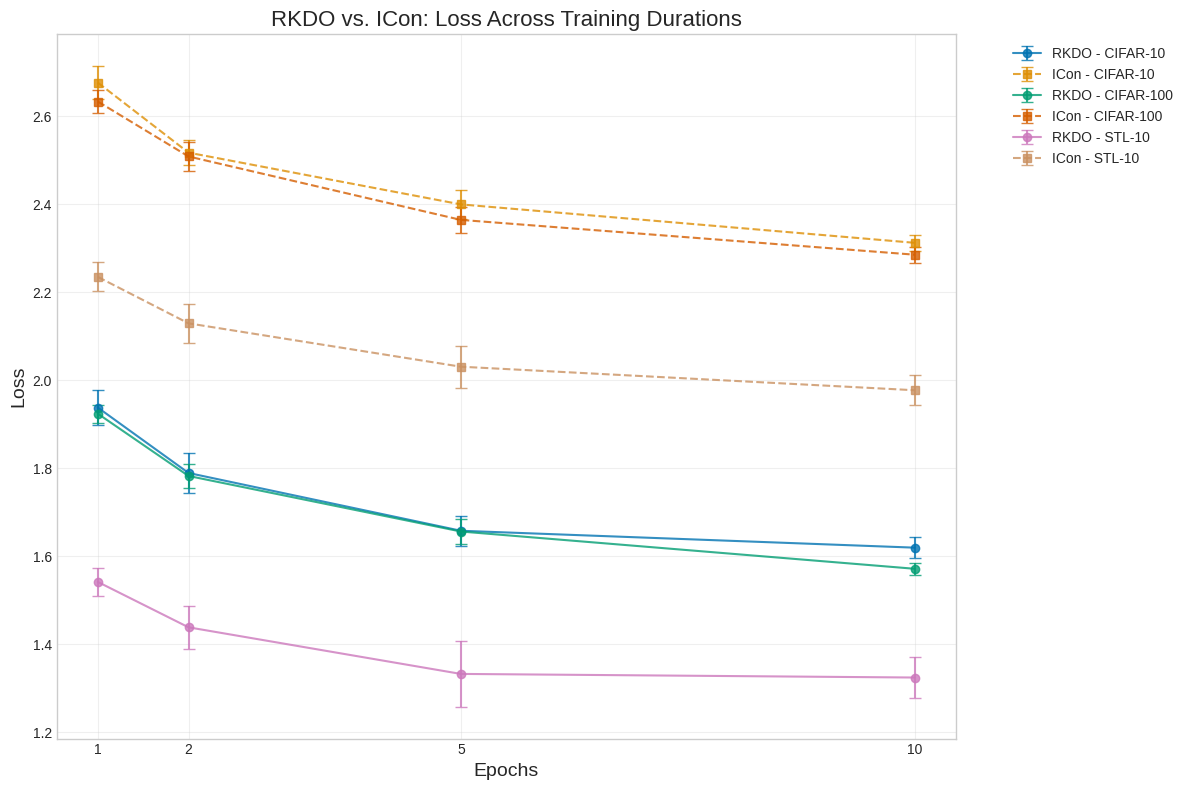

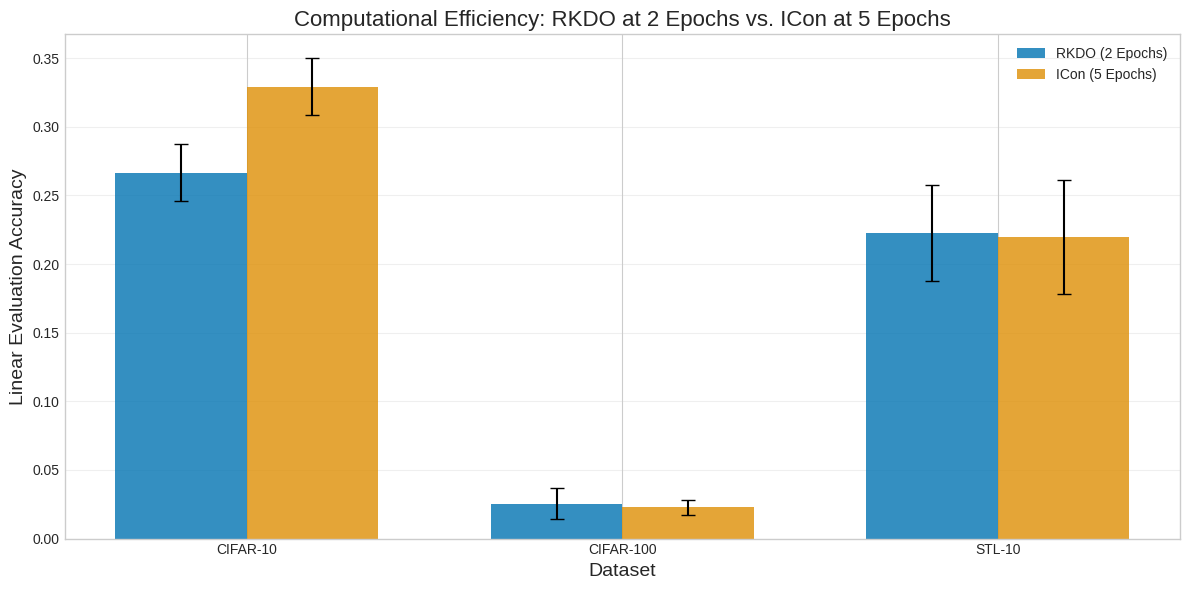

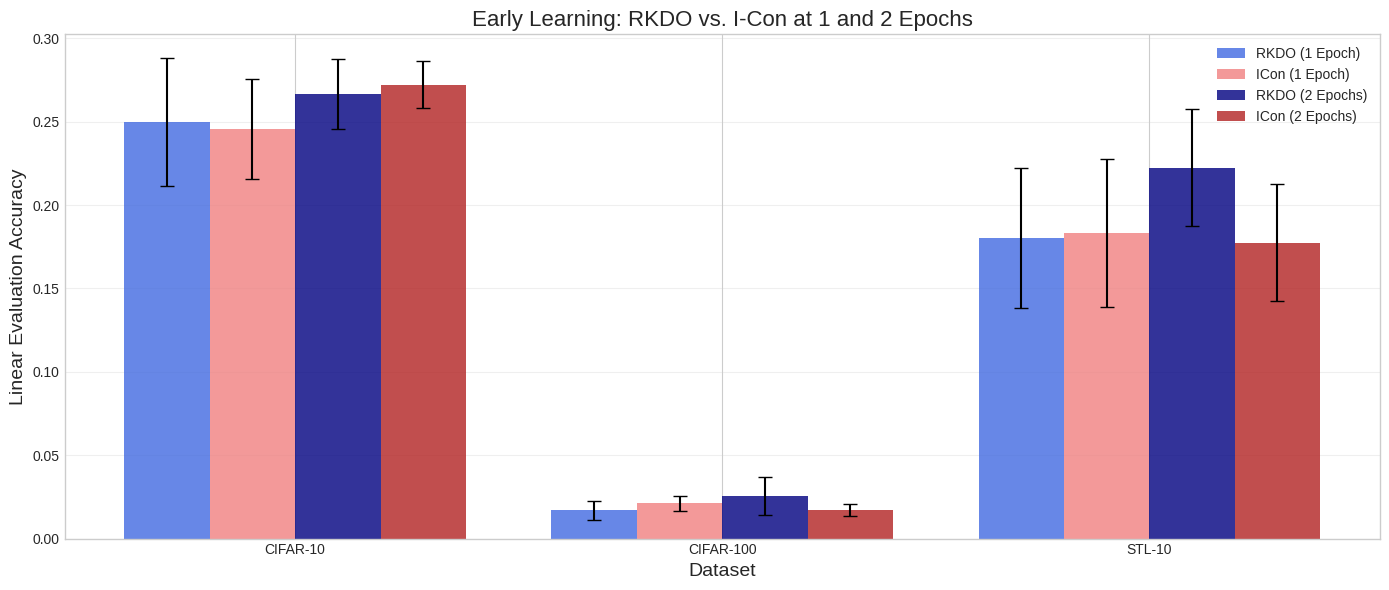

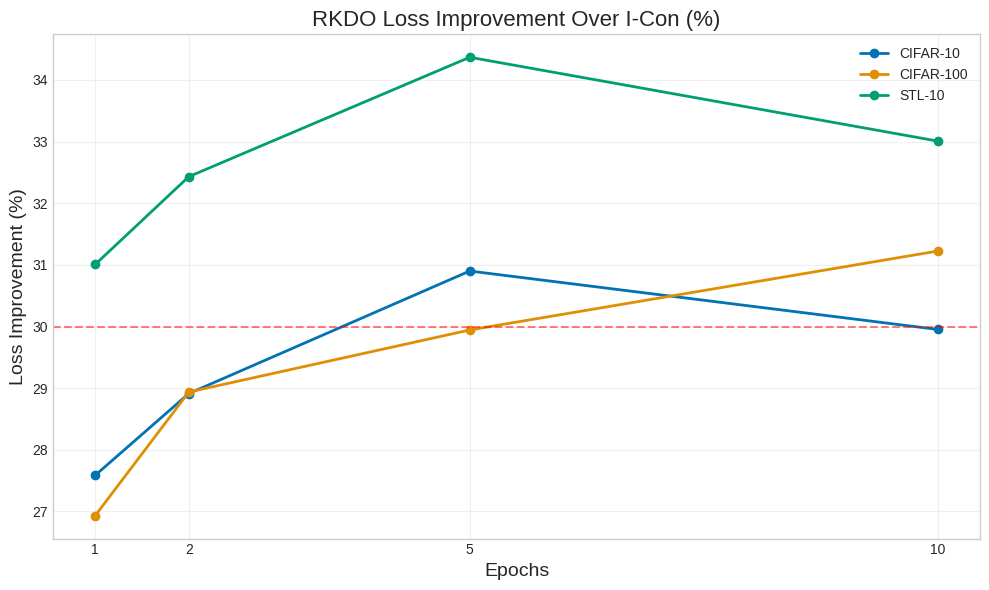

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Setting the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# Define our exact data from experiments
datasets = ['CIFAR-10', 'CIFAR-100', 'STL-10']

# Loss values (mean ± std)
loss_data = {
    'Dataset': np.repeat(datasets, 4),
    'Epochs': np.tile([1, 2, 5, 10], 3),
    'RKDO_Loss_Mean': [
        # CIFAR-10
        1.9384, 1.7897, 1.6584, 1.6200,
        # CIFAR-100
        1.9245, 1.7829, 1.6567, 1.5720,
        # STL-10
        1.5422, 1.4390, 1.3331, 1.3249
    ],
    'RKDO_Loss_Std': [
        # CIFAR-10
        0.0403, 0.0445, 0.0335, 0.0233,
        # CIFAR-100
        0.0205, 0.0269, 0.0290, 0.0133,
        # STL-10
        0.0310, 0.0483, 0.0742, 0.0460
    ],
    'ICon_Loss_Mean': [
        # CIFAR-10
        2.6768, 2.5176, 2.4000, 2.3127,
        # CIFAR-100
        2.6338, 2.5089, 2.3648, 2.2857,
        # STL-10
        2.2353, 2.1297, 2.0312, 1.9777
    ],
    'ICon_Loss_Std': [
        # CIFAR-10
        0.0369, 0.0291, 0.0321, 0.0184,
        # CIFAR-100
        0.0251, 0.0337, 0.0301, 0.0184,
        # STL-10
        0.0329, 0.0451, 0.0473, 0.0344
    ]
}

# Linear evaluation accuracy (mean ± std)
acc_data = {
    'Dataset': np.repeat(datasets, 4),
    'Epochs': np.tile([1, 2, 5, 10], 3),
    'RKDO_Acc_Mean': [
        # CIFAR-10
        0.2496, 0.2667, 0.3078, 0.2894,
        # CIFAR-100
        0.0170, 0.0255, 0.0255, 0.0227,
        # STL-10
        0.1803, 0.2225, 0.2141, 0.2113
    ],
    'RKDO_Acc_Std': [
        # CIFAR-10
        0.0384, 0.0208, 0.0374, 0.0299,
        # CIFAR-100
        0.0057, 0.0115, 0.0072, 0.0113,
        # STL-10
        0.0422, 0.0350, 0.0559, 0.0367
    ],
    'ICon_Acc_Mean': [
        # CIFAR-10
        0.2454, 0.2723, 0.3291, 0.3206,
        # CIFAR-100
        0.0213, 0.0170, 0.0227, 0.0199,
        # STL-10
        0.1831, 0.1775, 0.2197, 0.2479
    ],
    'ICon_Acc_Std': [
        # CIFAR-10
        0.0300, 0.0139, 0.0208, 0.0192,
        # CIFAR-100
        0.0045, 0.0035, 0.0053, 0.0053,
        # STL-10
        0.0445, 0.0352, 0.0414, 0.0363
    ]
}

# Convert to pandas DataFrames
loss_df = pd.DataFrame(loss_data)
acc_df = pd.DataFrame(acc_data)

# FIGURE 1: Loss comparison across epochs
plt.figure(figsize=(12, 8))

for dataset in datasets:
    # Filter data for this dataset
    dataset_loss = loss_df[loss_df['Dataset'] == dataset]

    # Plot RKDO
    plt.errorbar(dataset_loss['Epochs'], dataset_loss['RKDO_Loss_Mean'],
                 yerr=dataset_loss['RKDO_Loss_Std'],
                 fmt='o-', label=f'RKDO - {dataset}', capsize=4, alpha=0.8)

    # Plot ICon
    plt.errorbar(dataset_loss['Epochs'], dataset_loss['ICon_Loss_Mean'],
                 yerr=dataset_loss['ICon_Loss_Std'],
                 fmt='s--', label=f'ICon - {dataset}', capsize=4, alpha=0.8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('RKDO vs. ICon: Loss Across Training Durations', fontsize=16)
plt.xticks([1, 2, 5, 10])
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('figure1_loss_comparison.png', dpi=300)
plt.show()

# FIGURE 2: 2 vs 5 epoch comparison (computational efficiency)
plt.figure(figsize=(12, 6))

x = np.arange(len(datasets))
width = 0.35

# Extract 2-epoch RKDO and 5-epoch ICon data
rdo_2epoch = acc_df[acc_df['Epochs'] == 2][['Dataset', 'RKDO_Acc_Mean', 'RKDO_Acc_Std']].sort_values('Dataset')
icon_5epoch = acc_df[acc_df['Epochs'] == 5][['Dataset', 'ICon_Acc_Mean', 'ICon_Acc_Std']].sort_values('Dataset')

rdo_means = rdo_2epoch['RKDO_Acc_Mean'].values
rdo_stds = rdo_2epoch['RKDO_Acc_Std'].values
icon_means = icon_5epoch['ICon_Acc_Mean'].values
icon_stds = icon_5epoch['ICon_Acc_Std'].values

plt.bar(x - width/2, rdo_means, width, yerr=rdo_stds,
        label='RKDO (2 Epochs)', capsize=5, alpha=0.8)
plt.bar(x + width/2, icon_means, width, yerr=icon_stds,
        label='ICon (5 Epochs)', capsize=5, alpha=0.8)

plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Linear Evaluation Accuracy', fontsize=14)
plt.title('Computational Efficiency: RKDO at 2 Epochs vs. ICon at 5 Epochs', fontsize=16)
plt.xticks(x, datasets)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig('figure2_computational_efficiency.png', dpi=300)
plt.show()

# FIGURE 3: 1 vs 2 epoch comparison (early learning)
plt.figure(figsize=(14, 6))

x = np.arange(len(datasets))
width = 0.2

# Extract data for epochs 1 and 2
rdo_1epoch = acc_df[acc_df['Epochs'] == 1][['Dataset', 'RKDO_Acc_Mean', 'RKDO_Acc_Std']].sort_values('Dataset')
icon_1epoch = acc_df[acc_df['Epochs'] == 1][['Dataset', 'ICon_Acc_Mean', 'ICon_Acc_Std']].sort_values('Dataset')
rdo_2epoch = acc_df[acc_df['Epochs'] == 2][['Dataset', 'RKDO_Acc_Mean', 'RKDO_Acc_Std']].sort_values('Dataset')
icon_2epoch = acc_df[acc_df['Epochs'] == 2][['Dataset', 'ICon_Acc_Mean', 'ICon_Acc_Std']].sort_values('Dataset')

plt.bar(x - 3*width/2, rdo_1epoch['RKDO_Acc_Mean'].values, width, yerr=rdo_1epoch['RKDO_Acc_Std'].values,
        label='RKDO (1 Epoch)', capsize=5, alpha=0.8, color='royalblue')
plt.bar(x - width/2, icon_1epoch['ICon_Acc_Mean'].values, width, yerr=icon_1epoch['ICon_Acc_Std'].values,
        label='ICon (1 Epoch)', capsize=5, alpha=0.8, color='lightcoral')
plt.bar(x + width/2, rdo_2epoch['RKDO_Acc_Mean'].values, width, yerr=rdo_2epoch['RKDO_Acc_Std'].values,
        label='RKDO (2 Epochs)', capsize=5, alpha=0.8, color='navy')
plt.bar(x + 3*width/2, icon_2epoch['ICon_Acc_Mean'].values, width, yerr=icon_2epoch['ICon_Acc_Std'].values,
        label='ICon (2 Epochs)', capsize=5, alpha=0.8, color='firebrick')

plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Linear Evaluation Accuracy', fontsize=14)
plt.title('Early Learning: RKDO vs. I-Con at 1 and 2 Epochs', fontsize=16)
plt.xticks(x, datasets)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig('figure3_early_learning.png', dpi=300)
plt.show()

# Compute the improvement percentages for loss reduction
loss_df['Improvement'] = (loss_df['ICon_Loss_Mean'] - loss_df['RKDO_Loss_Mean']) / loss_df['ICon_Loss_Mean'] * 100

# Create a bonus figure showing the loss improvement percentage by epochs
plt.figure(figsize=(10, 6))
for dataset in datasets:
    dataset_loss = loss_df[loss_df['Dataset'] == dataset]
    plt.plot(dataset_loss['Epochs'], dataset_loss['Improvement'], 'o-',
             label=dataset, linewidth=2)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss Improvement (%)', fontsize=14)
plt.title('RKDO Loss Improvement Over I-Con (%)', fontsize=16)
plt.xticks([1, 2, 5, 10])
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='30% Threshold')
plt.tight_layout()
plt.savefig('bonus_improvement_percentage.png', dpi=300)
plt.show()

In [ ]:
# =============================================================
#  RDF vs I‑Con Benchmark — full, profiler‑ready version
#  Author: Anthony Martin  <am@cadenzai.net>
# =============================================================
"""
Key additions beyond the previous draft
--------------------------------------
1.  `profile_step_flops` — torch.profiler helper that measures FLOPs for a
    single forward–backward–optimiser step.  Gives an exact per‑step
    compute figure you can cite.
2.  `RepresentationLearner.train(do_profile=...)` — optional step‑profiling
    on the *first* mini‑batch of epoch 0.
3.  Side‑by‑side recursion‑depth FLOP check (depth = 1 vs. configured
    depth) when the "rkdo" framework is selected.
4.  Hygiene
      • removed PIL round‑trip in `ContrastiveDataset`
      • `max_batches_per_epoch` is now a config knob (default 10 for
        notebook demo, set None for full training)
      • unified `num_workers = 4` for fair timing.
"""

import os, time, math, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --------------------------------------------------------------
#  Dataset helpers
# --------------------------------------------------------------

def get_datasets(name: str):
    """Return (train_ds, test_ds, augment_tf) tuple."""

    base_tf = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3),
    ])
    aug_tf = transforms.Compose([
        transforms.Resize(32),
        transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3),
    ])

    if name == "cifar10":
        tr = datasets.CIFAR10("./data", True, download=True, transform=None)  # keep PIL for aug
        te = datasets.CIFAR10("./data", False, download=True, transform=base_tf)
        return tr, te, aug_tf

    if name == "cifar100":
        tr = datasets.CIFAR100("./data", True, download=True, transform=None)  # keep PIL
        te = datasets.CIFAR100("./data", False, download=True, transform=base_tf)
        return tr, te, aug_tf

    if name == "stl10":
        size  = 64
        base_tf_stl = transforms.Compose([
            transforms.Resize(size), transforms.ToTensor(),
            transforms.Normalize((0.5,)*3, (0.5,)*3),
        ])
        aug_tf_stl = transforms.Compose([
            transforms.Resize(size),
            transforms.RandomResizedCrop(size, scale=(0.2,1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,)*3, (0.5,)*3),
        ])
        tr = datasets.STL10("./data", split="train", download=True, transform=None)  # keep PIL
        te = datasets.STL10("./data", split="test",  download=True, transform=base_tf_stl)
        return tr, te, aug_tf_stl

    raise ValueError(f"Unsupported dataset {name}")

# --------------------------------------------------------------
#  Config
# --------------------------------------------------------------

class Config:
    def __init__(self, dataset="cifar10"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = 32 if dataset == "stl10" else 64
        self.num_epochs = 10
        self.max_batches_per_epoch = 10   # None => full epoch
        self.lr = 1e-3
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5
        # RDF hyper‑params
        self.rkdo_recursion_depth = 3
        self.rkdo_coupling_strength = 0.5
        # I‑Con hyper‑params
        self.icon_debias_alpha = 0.2

# --------------------------------------------------------------
#  Contrastive view dataset (no PIL round‑trip)
# --------------------------------------------------------------

class ContrastiveDataset(Dataset):
    def __init__(self, base_ds, aug_tf):
        self.base_ds, self.aug_tf = base_ds, aug_tf

    def __getitem__(self, idx):
        img, label = self.base_ds[idx]
        v1, v2 = self.aug_tf(img), self.aug_tf(img)
        return v1, v2, label

    def __len__(self):
        return len(self.base_ds)

# --------------------------------------------------------------
#  Encoder + proj‑head
# --------------------------------------------------------------

class EncoderNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.backbone = models.resnet18(weights=None)
        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.proj = nn.Sequential(
            nn.Linear(feat_dim, feat_dim), nn.ReLU(), nn.Linear(feat_dim, embedding_dim))

    def forward(self, x):
        z = self.backbone(x)
        z = F.normalize(self.proj(z), dim=1)
        return z

# --------------------------------------------------------------
#  Frameworks
# --------------------------------------------------------------

class RDF:
    def __init__(self, cfg: Config):
        self.d = cfg.rkdo_recursion_depth
        self.alpha = cfg.rkdo_coupling_strength
        self.temp = cfg.temperature
        self.device = cfg.device

    def compute_loss(self, z1, z2):
        B = z1.size(0)
        p = torch.eye(B, device=self.device)           # p^(0)
        sim = (z1 @ z2.T) / self.temp
        q = F.softmax(sim, dim=1)                      # q^(0)
        loss = 0.
        for t in range(1, self.d+1):
            p = (1-self.alpha)*p + self.alpha*q        # p^(t)
            temp_t = self.temp * (1 - 0.1*t/self.d)
            q = F.softmax((z1 @ z2.T)/temp_t, dim=1)   # q^(t)
            loss += F.kl_div(q.log(), p, reduction="batchmean")
        return loss

class ICon:
    def __init__(self, cfg: Config):
        self.temp = cfg.temperature
        self.alpha = cfg.icon_debias_alpha
        self.device = cfg.device

    def compute_loss(self, z1, z2):
        B = z1.size(0)
        p = torch.eye(B, device=self.device)
        if self.alpha > 0:
            p = (1-self.alpha)*p + self.alpha*(torch.ones_like(p)/B)
        q = F.softmax((z1 @ z2.T)/self.temp, dim=1)
        return F.kl_div(q.log(), p, reduction="batchmean")

# --------------------------------------------------------------
#  Profiler helper
# --------------------------------------------------------------

def profile_step_flops(model, loss_fn, optimiser, v1, v2):
    import torch.profiler as prof
    with prof.profile(activities=[prof.ProfilerActivity.CPU, prof.ProfilerActivity.CUDA],
                      with_flops=True, record_shapes=False, profile_memory=False) as p:
        optimiser.zero_grad()
        loss = loss_fn(model(v1), model(v2))
        loss.backward(); optimiser.step()
    return p.key_averages().total_average().flops

# --------------------------------------------------------------
#  Learner
# --------------------------------------------------------------

class RepresentationLearner:
    def __init__(self, framework, cfg: Config):
        self.cfg, self.framework = cfg, framework
        self.model = EncoderNetwork(cfg.embedding_dim).to(cfg.device)
        self.opt = optim.Adam(self.model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        self.train_losses = []

    def train(self, loader, test_loader, do_profile=False):
        step_flops = None
        for ep in range(self.cfg.num_epochs):
            self.model.train(); epoch_loss = 0; n = 0
            for i, (v1, v2, _) in enumerate(tqdm(loader, disable=False)):
                if self.cfg.max_batches_per_epoch and i >= self.cfg.max_batches_per_epoch:
                    break
                v1, v2 = v1.to(self.cfg.device), v2.to(self.cfg.device)

                # optional one‑off profiler on first batch
                if do_profile and step_flops is None and ep == 0 and i == 0:
                    step_flops = profile_step_flops(self.model, self.framework.compute_loss,
                                                     self.opt, v1, v2)
                    giga = step_flops/1e9
                    print(f"[Profiler] {giga:.2f} GFLOPs per step")

                self.opt.zero_grad()
                loss = self.framework.compute_loss(self.model(v1), self.model(v2))
                loss.backward(); self.opt.step()
                epoch_loss += loss.item(); n += 1
            self.train_losses.append(epoch_loss/n)
            print(f"Epoch {ep+1}: loss={epoch_loss/n:.4f}")
            if (ep+1) % 5 == 0 or ep == self.cfg.num_epochs-1:
                self.evaluate(test_loader)
        return step_flops  # may be None

    def evaluate(self, loader):
        self.model.eval(); feats, labels = [], []
        with torch.no_grad():
            for i, (imgs, y) in enumerate(loader):
                if self.cfg.max_batches_per_epoch and i >= self.cfg.max_batches_per_epoch:
                    break
                f = self.model(imgs.to(self.cfg.device)).cpu().numpy()
                feats.append(f); labels.append(y.numpy())
        X = np.vstack(feats); y = np.concatenate(labels)
        # linear eval
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
        acc = LogisticRegression(max_iter=1000).fit(Xtr, ytr).score(Xte, yte)
        # clustering
        kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42).fit(X)
        nmi = normalized_mutual_info_score(y, kmeans.labels_)
        ari = adjusted_rand_score(y, kmeans.labels_)
        # knn preservation
        knn = NearestNeighbors(n_neighbors=6).fit(X)
        _, idx = knn.kneighbors(X)
        knn_acc = np.mean([ y[i]==y[idx[i, j]] for i in range(len(X)) for j in range(1,6) ])
        print(f"Eval — linear:{acc:.3f}  nmi:{nmi:.3f}  ari:{ari:.3f}  knn:{knn_acc:.3f}")
        return dict(linear=acc, nmi=nmi, ari=ari, knn=knn_acc)

# --------------------------------------------------------------
#  Benchmark harness
# --------------------------------------------------------------

def run_benchmark(dataset="cifar10", frameworks=("rkdo","icon")):
    tr_ds, te_ds, aug_tf = get_datasets(dataset)
    cfg = Config(dataset)
    tr_loader = DataLoader(ContrastiveDataset(tr_ds, aug_tf), batch_size=cfg.batch_size,
                           shuffle=True, num_workers=0)  # single‑process to avoid MP shutdown glitch)
    te_loader = DataLoader(te_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0)  # single‑process to avoid MP shutdown glitch)

    results = {}
    for fw in frameworks:
        print(f"=== {fw.upper()} ===")
        fw_obj = RDF(cfg) if fw=="rkdo" else ICon(cfg)
        # optional depth‑sweep profiler for RDF
        if fw == "rkdo":
            for d in [1, cfg.rkdo_recursion_depth]:
                old, fw_obj.d = fw_obj.d, d
                step_flops = RepresentationLearner(fw_obj, cfg).train(tr_loader, te_loader, do_profile=True)
                fw_obj.d = old
                print(f"Depth {d} → {step_flops/1e9:.2f} GFLOPs/step")
        learner = RepresentationLearner(fw_obj, cfg)
        start = time.time()
        learner.train(tr_loader, te_loader, do_profile=(fw!="rkdo"))
        wall = time.time()-start
        print(f"Training wall‑time: {wall/60:.1f} min")
        results[fw] = dict(losses=learner.train_losses)
    return results

# --------------------------------------------------------------
#  Entry‑point helper for notebooks
# --------------------------------------------------------------

if __name__ == "__main__":
    # Minimal quick run
    random.seed(0); np.random.seed(0); torch.manual_seed(0)
    run_benchmark("cifar10")


=== RKDO ===


  0%|          | 0/782 [00:00<?, ?it/s]

[Profiler] 9.70 GFLOPs per step
Epoch 1: loss=1.2689


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: loss=1.1816


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: loss=1.1452


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: loss=1.1726


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: loss=1.1749
Eval — linear:0.234  nmi:0.162  ari:0.075  knn:0.190


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6: loss=1.1470


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7: loss=1.1167


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8: loss=1.1230


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9: loss=1.0623


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: loss=1.0698
Eval — linear:0.289  nmi:0.188  ari:0.087  knn:0.212
Depth 1 → 9.70 GFLOPs/step


  0%|          | 0/782 [00:00<?, ?it/s]

[Profiler] 9.71 GFLOPs per step
Epoch 1: loss=1.9237


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: loss=1.7776


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: loss=1.7545


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: loss=1.7371


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: loss=1.7209
Eval — linear:0.242  nmi:0.166  ari:0.086  knn:0.201


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6: loss=1.6231


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7: loss=1.6092


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8: loss=1.6323


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9: loss=1.5825


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: loss=1.5875
Eval — linear:0.242  nmi:0.192  ari:0.093  knn:0.230
Depth 3 → 9.71 GFLOPs/step


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: loss=1.9504


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: loss=1.8372


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: loss=1.7567


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: loss=1.6748


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: loss=1.6633
Eval — linear:0.180  nmi:0.141  ari:0.059  knn:0.180


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6: loss=1.6574


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7: loss=1.6389


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8: loss=1.6363


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9: loss=1.6833


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: loss=1.6399
Eval — linear:0.258  nmi:0.159  ari:0.070  knn:0.184
Training wall‑time: 0.3 min
=== ICON ===


  0%|          | 0/782 [00:00<?, ?it/s]

[Profiler] 9.70 GFLOPs per step
Epoch 1: loss=2.6417


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: loss=2.5192


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: loss=2.4789


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: loss=2.4235


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: loss=2.3619
Eval — linear:0.227  nmi:0.156  ari:0.087  knn:0.189


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6: loss=2.3773


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7: loss=2.3432


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8: loss=2.3167


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9: loss=2.2863


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: loss=2.3256
Eval — linear:0.273  nmi:0.148  ari:0.061  knn:0.209
Training wall‑time: 0.3 min


In [ ]:
# =============================================================
#  RKDO vs I-Con Benchmark — profiler-ready
#  Author: Anthony Martin  <am@cadenzai.net>
#  Cleaned & unified by ChatGPT 2025-04-30
# =============================================================

import os, time, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

# ------------------------------------------------------------------
#  Deterministic kernels for repeatable FLOP counts
# ------------------------------------------------------------------
torch.backends.cudnn.benchmark     = False
torch.backends.cudnn.deterministic = True

# ------------------------------------------------------------------
#  Constants
# ------------------------------------------------------------------
N_PROF = 20          # forward-only traces per depth for FLOP stats

# ------------------------------------------------------------------
#  Dataset helpers
# ------------------------------------------------------------------
def get_datasets(name: str):
    base_tf = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])
    aug_tf = transforms.Compose([
        transforms.Resize(32),
        transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])

    if name == "cifar10":
        tr = datasets.CIFAR10("./data", train=True,  download=True, transform=None)  # keep PIL
        te = datasets.CIFAR10("./data", train=False, download=True, transform=base_tf)
        return tr, te, aug_tf

    if name == "cifar100":
        tr = datasets.CIFAR100("./data", True,  download=True, transform=None)
        te = datasets.CIFAR100("./data", False, download=True, transform=base_tf)
        return tr, te, aug_tf

    if name == "stl10":
        size = 64
        base_tf_stl = transforms.Compose([
            transforms.Resize(size), transforms.ToTensor(),
            transforms.Normalize((0.5,)*3, (0.5,)*3)
        ])
        aug_tf_stl = transforms.Compose([
            transforms.Resize(size),
            transforms.RandomResizedCrop(size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,)*3, (0.5,)*3)
        ])
        tr = datasets.STL10("./data", split="train", download=True, transform=None)
        te = datasets.STL10("./data", split="test",  download=True, transform=base_tf_stl)
        return tr, te, aug_tf_stl

    raise ValueError(name)

# ------------------------------------------------------------------
#  Config
# ------------------------------------------------------------------
class Config:
    def __init__(self, dataset="cifar10"):
        self.device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = 32 if dataset == "stl10" else 64
        self.num_epochs = 10
        self.max_batches_per_epoch = 10   # None → full epoch
        self.lr = 1e-3
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5
        # RKDO
        self.rkdo_depth  = 3
        self.rkdo_alpha  = 0.5
        # I-Con
        self.icon_alpha  = 0.2

# ------------------------------------------------------------------
#  Contrastive dataset
# ------------------------------------------------------------------
class ContrastiveDataset(Dataset):
    def __init__(self, base_ds, aug_tf):
        self.base_ds, self.aug_tf = base_ds, aug_tf
    def __getitem__(self, idx):
        img, y = self.base_ds[idx]
        return self.aug_tf(img), self.aug_tf(img), y
    def __len__(self): return len(self.base_ds)

# ------------------------------------------------------------------
#  Encoder + projection head
# ------------------------------------------------------------------
class EncoderNetwork(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.backbone = models.resnet18(weights=None)
        feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.proj = nn.Sequential(nn.Linear(feat, feat), nn.ReLU(), nn.Linear(feat, emb_dim))
    def forward(self,x): return F.normalize(self.proj(self.backbone(x)), dim=1)

# ------------------------------------------------------------------
#  Frameworks
# ------------------------------------------------------------------
class RKDO:
    def __init__(self,cfg):
        self.d     = cfg.rkdo_depth
        self.alpha = cfg.rkdo_alpha
        self.temp  = cfg.temperature
        self.device= cfg.device
    def compute_loss(self,z1,z2):
        B = z1.size(0)
        p = torch.eye(B,device=self.device)
        q = F.softmax((z1@z2.T)/self.temp,dim=1)
        loss = 0.
        for t in range(1,self.d+1):
            p = (1-self.alpha)*p + self.alpha*q
            q = F.softmax((z1@z2.T)/(self.temp*(1-0.1*t/self.d)), dim=1)
            loss += F.kl_div(q.log(), p, reduction="batchmean")
        return loss

class ICon:
    def __init__(self,cfg):
        self.temp  = cfg.temperature
        self.alpha = cfg.icon_alpha
        self.device= cfg.device
    def compute_loss(self,z1,z2):
        B = z1.size(0)
        p = torch.eye(B,device=self.device)
        if self.alpha>0:
            p = (1-self.alpha)*p + self.alpha*(torch.ones_like(p)/B)
        q = F.softmax((z1@z2.T)/self.temp,dim=1)
        return F.kl_div(q.log(), p, reduction="batchmean")

# ------------------------------------------------------------------
#  Forward-only FLOP profiler
# ------------------------------------------------------------------
def profile_step_flops(model, loss_fn, v1, v2):
    import torch.profiler as prof
    with torch.inference_mode():
        with prof.profile(activities=[prof.ProfilerActivity.CPU,
                                      prof.ProfilerActivity.CUDA],
                          with_flops=True, record_shapes=False,
                          profile_memory=False) as p:
            loss_fn(model(v1), model(v2))
    return p.key_averages().total_average().flops

# ------------------------------------------------------------------
#  Learner
# ------------------------------------------------------------------
class RepresentationLearner:
    def __init__(self, framework, cfg):
        self.cfg, self.framework = cfg, framework
        self.model = EncoderNetwork(cfg.embedding_dim).to(cfg.device)
        self.opt   = optim.Adam(self.model.parameters(), lr=cfg.lr,
                                weight_decay=cfg.weight_decay)
        self.train_losses = []

    def train(self, loader, test_loader, do_profile=False, results=None):
        step_flops = None
        for ep in range(self.cfg.num_epochs):
            self.model.train(); epoch_loss=0; n=0
            for i,(v1,v2,_) in enumerate(tqdm(loader,disable=False)):
                if self.cfg.max_batches_per_epoch and i>=self.cfg.max_batches_per_epoch:
                    break
                v1,v2 = v1.to(self.cfg.device), v2.to(self.cfg.device)

                # profiler on first batch
                if do_profile and step_flops is None and ep==0 and i==0:
                    fl=[profile_step_flops(self.model,
                                           self.framework.compute_loss,
                                           v1,v2)
                        for _ in range(N_PROF)]
                    mu, sd = np.mean(fl), np.std(fl,ddof=1)
                    print(f"[Profiler] {mu/1e9:.2f} ± {sd/1e9:.2f} GFLOPs/step (n={N_PROF})")
                    step_flops = mu
                    if results is not None:
                        results.setdefault('prof',[]).append(
                            dict(depth=getattr(self.framework,'d',1),
                                 mean_gflops=mu/1e9, std_gflops=sd/1e9))

                self.opt.zero_grad(set_to_none=True)
                loss = self.framework.compute_loss(self.model(v1), self.model(v2))
                loss.backward(); self.opt.step()
                epoch_loss += loss.item(); n += 1

            self.train_losses.append(epoch_loss/n)
            print(f"Epoch {ep+1}: loss={epoch_loss/n:.4f}")
            if (ep+1)%5==0 or ep==self.cfg.num_epochs-1:
                self.evaluate(test_loader)
        return step_flops

    def evaluate(self, loader):
        self.model.eval(); feats,labels=[],[]
        with torch.no_grad():
            for i,(imgs,y) in enumerate(loader):
                if self.cfg.max_batches_per_epoch and i>=self.cfg.max_batches_per_epoch:
                    break
                feats.append(self.model(imgs.to(self.cfg.device)).cpu().numpy())
                labels.append(y.numpy())
        X=np.vstack(feats); y=np.concatenate(labels)
        Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=42)
        acc = LogisticRegression(max_iter=1000).fit(Xtr,ytr).score(Xte,yte)
        kmeans = KMeans(n_clusters=len(np.unique(y)),random_state=42).fit(X)
        nmi = normalized_mutual_info_score(y,kmeans.labels_)
        ari = adjusted_rand_score(y,kmeans.labels_)
        knn = NearestNeighbors(n_neighbors=6).fit(X)
        _,idx = knn.kneighbors(X)
        knn_acc = np.mean([y[i]==y[idx[i,j]] for i in range(len(X)) for j in range(1,6)])
        print(f"Eval — linear:{acc:.3f}  nmi:{nmi:.3f}  ari:{ari:.3f}  knn:{knn_acc:.3f}")

# ------------------------------------------------------------------
#  Benchmark harness
# ------------------------------------------------------------------
def run_benchmark(dataset="cifar10", frameworks=("rkdo","icon")):
    tr_ds,te_ds,aug_tf = get_datasets(dataset)
    cfg = Config(dataset)
    tr_loader = DataLoader(ContrastiveDataset(tr_ds,aug_tf),
                           batch_size=cfg.batch_size,shuffle=True,num_workers=0)
    te_loader = DataLoader(te_ds,batch_size=cfg.batch_size,
                           shuffle=False,num_workers=0)

    for fw in frameworks:
        print(f"=== {fw.upper()} ===")
        fw_obj = RKDO(cfg) if fw=="rkdo" else ICon(cfg)

        # optional depth sweep for RKDO
        if fw=="rkdo":
            for d in [1, cfg.rkdo_depth]:
                old = fw_obj.d; fw_obj.d = d
                RepresentationLearner(fw_obj,cfg).train(
                    tr_loader, te_loader, do_profile=True)
                fw_obj.d = old

        learner = RepresentationLearner(fw_obj, cfg)
        t0=time.time()
        learner.train(tr_loader, te_loader, do_profile=(fw!="rkdo"))
        print(f"Training wall-time: {(time.time()-t0)/60:.1f} min")

# ------------------------------------------------------------------
if __name__ == "__main__":
    random.seed(0); np.random.seed(0); torch.manual_seed(0)
    run_benchmark("cifar10")


=== RKDO ===


  0%|          | 0/782 [00:00<?, ?it/s]

[Profiler] 9.55 ± 0.00 GFLOPs/step (n=20)
Epoch 1: loss=1.3120


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: loss=1.1734


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: loss=1.1354


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: loss=1.1482


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: loss=1.1657
Eval — linear:0.242  nmi:0.166  ari:0.091  knn:0.197


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6: loss=1.1405


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7: loss=1.1056


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8: loss=1.1188


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9: loss=1.0648


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: loss=1.0545
Eval — linear:0.258  nmi:0.187  ari:0.079  knn:0.194


  0%|          | 0/782 [00:00<?, ?it/s]

[Profiler] 9.55 ± 0.00 GFLOPs/step (n=20)
Epoch 1: loss=1.9948


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: loss=1.7326


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: loss=1.7567


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: loss=1.6936


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: loss=1.6563
Eval — linear:0.180  nmi:0.147  ari:0.068  knn:0.183


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6: loss=1.5925


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7: loss=1.6121


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8: loss=1.6307


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9: loss=1.5927


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: loss=1.5672
Eval — linear:0.281  nmi:0.173  ari:0.079  knn:0.220


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: loss=1.9517


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: loss=1.8436


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: loss=1.7589


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: loss=1.6656


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: loss=1.6201
Eval — linear:0.203  nmi:0.132  ari:0.053  knn:0.178


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6: loss=1.6586


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7: loss=1.6781


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8: loss=1.6520


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9: loss=1.6757


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: loss=1.6276
Eval — linear:0.289  nmi:0.164  ari:0.083  knn:0.210
Training wall-time: 0.3 min
=== ICON ===


  0%|          | 0/782 [00:00<?, ?it/s]

[Profiler] 9.55 ± 0.00 GFLOPs/step (n=20)
Epoch 1: loss=2.6590


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: loss=2.5025


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: loss=2.4341


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: loss=2.4732


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: loss=2.3558
Eval — linear:0.219  nmi:0.127  ari:0.049  knn:0.169


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6: loss=2.3896


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7: loss=2.3640


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8: loss=2.3566


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9: loss=2.3075


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10: loss=2.3405
Eval — linear:0.305  nmi:0.161  ari:0.064  knn:0.202
Training wall-time: 0.4 min


In [ ]:
# =============================================================
#  RKDO vs I-Con Benchmark — profiler-ready
#  Author:  Anthony Martin <am@cadenzai.net>
#  Cleaned & unified by ChatGPT 2025-04-30
#
#  + ImageNet-100 support (224×224)                     2025-04-30
#    • set IMAGENET100_ROOT=/path/to/imagenet100 or keep default
#    • folder layout must follow torchvision ImageFolder convention:
#         imagenet100/
#             train/n01440764/*.JPEG …
#             ...
#             val/n01440764/*.JPEG …
#             ...
# =============================================================

import os, time, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

# ------------------------------------------------------------------
#  Deterministic kernels for repeatable FLOP counts
# ------------------------------------------------------------------
torch.backends.cudnn.benchmark     = False
torch.backends.cudnn.deterministic = True

# ------------------------------------------------------------------
#  Constants
# ------------------------------------------------------------------
N_PROF = 20          # forward-only traces per depth for FLOP stats

# ------------------------------------------------------------------
#  Dataset helpers
# ------------------------------------------------------------------
def get_datasets(name: str):
    """Return (train_dataset[PIL],  val_dataset[Tensor],  augment_tf)"""
    # --- common 32×32 transforms ------------------------------------------------
    base_tf_32 = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])
    aug_tf_32 = transforms.Compose([
        transforms.Resize(32),
        transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])

    # ---------------- CIFAR-10 --------------------------------------------------
    if name == "cifar10":
        tr = datasets.CIFAR10("./data", train=True,  download=True, transform=None)
        te = datasets.CIFAR10("./data", train=False, download=True, transform=base_tf_32)
        return tr, te, aug_tf_32

    # ---------------- CIFAR-100 -------------------------------------------------
    if name == "cifar100":
        tr = datasets.CIFAR100("./data", True,  download=True, transform=None)
        te = datasets.CIFAR100("./data", False, download=True, transform=base_tf_32)
        return tr, te, aug_tf_32

    # ---------------- STL-10 (64×64) -------------------------------------------
    if name == "stl10":
        size = 64
        base_tf_64 = transforms.Compose([
            transforms.Resize(size), transforms.ToTensor(),
            transforms.Normalize((0.5,)*3, (0.5,)*3)
        ])
        aug_tf_64 = transforms.Compose([
            transforms.Resize(size),
            transforms.RandomResizedCrop(size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,)*3, (0.5,)*3)
        ])
        tr = datasets.STL10("./data", split="train", download=True, transform=None)
        te = datasets.STL10("./data", split="test",  download=True, transform=base_tf_64)
        return tr, te, aug_tf_64

    # ---------------- ImageNet-100 (224×224) -----------------------------------
    if name == "imagenet100":
        root = os.environ.get("IMAGENET100_ROOT", "./imagenet100")
        train_dir = os.path.join(root, "train")
        val_dir   = os.path.join(root, "val")
        if not (os.path.isdir(train_dir) and os.path.isdir(val_dir)):
            raise FileNotFoundError(
                f"ImageNet-100 folders not found in {root}.  "
                "Download or generate the subset first.  "
                "See e.g. kaggle.com/ambityga/imagenet100 or "
                "github.com/danielchyeh/ImageNet-100-Pytorch" )

        size = 224
        base_tf_224 = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225)),
        ])
        aug_tf_224 = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225)),
        ])
        tr = datasets.ImageFolder(train_dir, transform=None)      # keep PIL
        te = datasets.ImageFolder(val_dir,   transform=base_tf_224)
        return tr, te, aug_tf_224

    # ---------------------------------------------------------------------------
    raise ValueError(f"Unknown dataset '{name}'")

# ------------------------------------------------------------------
#  Config
# ------------------------------------------------------------------
class Config:
    def __init__(self, dataset="cifar10"):
        self.device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if dataset == "imagenet100":
            # ResNet-18 + 224×224; tune batch size to your GPU
            self.batch_size = 128 if torch.cuda.is_available() else 32
            self.image_size = 224
        elif dataset == "stl10":
            self.batch_size = 32
            self.image_size = 64
        else:
            self.batch_size = 64
            self.image_size = 32

        self.num_epochs = 10
        self.max_batches_per_epoch = 10   # None → full epoch
        self.lr = 1e-3
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5
        # RKDO
        self.rkdo_depth  = 3
        self.rkdo_alpha  = 0.5
        # I-Con
        self.icon_alpha  = 0.2

# ------------------------------------------------------------------
#  Contrastive dataset
# ------------------------------------------------------------------
class ContrastiveDataset(Dataset):
    def __init__(self, base_ds, aug_tf):
        self.base_ds, self.aug_tf = base_ds, aug_tf
    def __getitem__(self, idx):
        img, y = self.base_ds[idx]
        return self.aug_tf(img), self.aug_tf(img), y
    def __len__(self): return len(self.base_ds)

# ------------------------------------------------------------------
#  Encoder + projection head
# ------------------------------------------------------------------
class EncoderNetwork(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.backbone = models.resnet18(weights=None)
        feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.proj = nn.Sequential(
            nn.Linear(feat, feat), nn.ReLU(), nn.Linear(feat, emb_dim)
        )
    def forward(self, x):
        return F.normalize(self.proj(self.backbone(x)), dim=1)

# ------------------------------------------------------------------
#  Frameworks
# ------------------------------------------------------------------
class RKDO:
    def __init__(self, cfg):
        self.d     = cfg.rkdo_depth
        self.alpha = cfg.rkdo_alpha
        self.temp  = cfg.temperature
        self.device= cfg.device
    def compute_loss(self, z1, z2):
        B = z1.size(0)
        p = torch.eye(B, device=self.device)
        q = F.softmax((z1 @ z2.T) / self.temp, dim=1)
        loss = 0.
        for t in range(1, self.d + 1):
            p = (1 - self.alpha) * p + self.alpha * q
            q = F.softmax((z1 @ z2.T) /
                          (self.temp * (1 - 0.1 * t / self.d)), dim=1)
            loss += F.kl_div(q.log(), p, reduction="batchmean")
        return loss

class ICon:
    def __init__(self, cfg):
        self.temp  = cfg.temperature
        self.alpha = cfg.icon_alpha
        self.device= cfg.device
    def compute_loss(self, z1, z2):
        B = z1.size(0)
        p = torch.eye(B, device=self.device)
        if self.alpha > 0:
            p = (1 - self.alpha) * p + self.alpha * (torch.ones_like(p) / B)
        q = F.softmax((z1 @ z2.T) / self.temp, dim=1)
        return F.kl_div(q.log(), p, reduction="batchmean")

# ------------------------------------------------------------------
#  Forward-only FLOP profiler
# ------------------------------------------------------------------
def profile_step_flops(model, loss_fn, v1, v2):
    import torch.profiler as prof
    with torch.inference_mode():
        with prof.profile(activities=[prof.ProfilerActivity.CPU,
                                      prof.ProfilerActivity.CUDA],
                          with_flops=True,
                          record_shapes=False,
                          profile_memory=False) as p:
            loss_fn(model(v1), model(v2))
    return p.key_averages().total_average().flops

# ------------------------------------------------------------------
#  Learner
# ------------------------------------------------------------------
class RepresentationLearner:
    def __init__(self, framework, cfg):
        self.cfg, self.framework = cfg, framework
        self.model = EncoderNetwork(cfg.embedding_dim).to(cfg.device)
        self.opt   = optim.Adam(self.model.parameters(), lr=cfg.lr,
                                weight_decay=cfg.weight_decay)
        self.train_losses = []

    # --------------------------------------------------------------
    def train(self, loader, test_loader, do_profile=False):
        step_flops = None
        for ep in range(self.cfg.num_epochs):
            self.model.train(); epoch_loss = 0; n = 0
            for i, (v1, v2, _) in enumerate(tqdm(loader, disable=False)):
                if self.cfg.max_batches_per_epoch and i >= self.cfg.max_batches_per_epoch:
                    break
                v1, v2 = v1.to(self.cfg.device), v2.to(self.cfg.device)

                # profiler on first batch
                if do_profile and step_flops is None and ep == 0 and i == 0:
                    fl = [profile_step_flops(self.model,
                                             self.framework.compute_loss,
                                             v1, v2)
                          for _ in range(N_PROF)]
                    mu, sd = np.mean(fl), np.std(fl, ddof=1)
                    print(f"[Profiler] {mu/1e9:.2f} ± {sd/1e9:.2f} GFLOPs/step (n={N_PROF})")
                    step_flops = mu

                self.opt.zero_grad(set_to_none=True)
                loss = self.framework.compute_loss(
                    self.model(v1), self.model(v2))
                loss.backward(); self.opt.step()
                epoch_loss += loss.item(); n += 1

            self.train_losses.append(epoch_loss / n)
            print(f"Epoch {ep + 1}: loss = {epoch_loss / n:.4f}")
            if (ep + 1) % 5 == 0 or ep == self.cfg.num_epochs - 1:
                self.evaluate(test_loader)

    # --------------------------------------------------------------
    def evaluate(self, loader):
        self.model.eval(); feats, labels = [], []
        with torch.no_grad():
            for i, (imgs, y) in enumerate(loader):
                if self.cfg.max_batches_per_epoch and i >= self.cfg.max_batches_per_epoch:
                    break
                feats.append(self.model(imgs.to(self.cfg.device)).cpu().numpy())
                labels.append(y.numpy())
        X = np.vstack(feats); y = np.concatenate(labels)
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
        acc = LogisticRegression(max_iter=1000).fit(Xtr, ytr).score(Xte, yte)
        kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42).fit(X)
        nmi = normalized_mutual_info_score(y, kmeans.labels_)
        ari = adjusted_rand_score(y, kmeans.labels_)
        knn = NearestNeighbors(n_neighbors=6).fit(X)
        _, idx = knn.kneighbors(X)
        knn_acc = np.mean([y[i] == y[idx[i, j]] for i in range(len(X)) for j in range(1, 6)])
        print(f"Eval — linear:{acc:.3f}  nmi:{nmi:.3f}  ari:{ari:.3f}  knn:{knn_acc:.3f}")

# ------------------------------------------------------------------
#  Benchmark harness
# ------------------------------------------------------------------
def run_benchmark(dataset="cifar10", frameworks=("rkdo", "icon")):
    tr_ds, te_ds, aug_tf = get_datasets(dataset)
    cfg = Config(dataset)

    tr_loader = DataLoader(
        ContrastiveDataset(tr_ds, aug_tf),
        batch_size=cfg.batch_size, shuffle=True, num_workers=0)
    te_loader = DataLoader(
        te_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0)

    for fw in frameworks:
        print(f"\n=== {fw.upper()} — {dataset.upper()} ===")
        fw_obj = RKDO(cfg) if fw == "rkdo" else ICon(cfg)

        # optional depth sweep for RKDO
        if fw == "rkdo":
            for d in [1, cfg.rkdo_depth]:
                old_d = fw_obj.d; fw_obj.d = d
                RepresentationLearner(fw_obj, cfg).train(
                    tr_loader, te_loader, do_profile=True)
                fw_obj.d = old_d

        RepresentationLearner(fw_obj, cfg).train(
            tr_loader, te_loader, do_profile=(fw != "rkdo"))

# ------------------------------------------------------------------
if __name__ == "__main__":
    random.seed(0); np.random.seed(0); torch.manual_seed(0)
    run_benchmark("imagenet100")       # change to "imagenet100", "cifar100", "stl10" etc.


FileNotFoundError: ImageNet-100 folders not found in ./imagenet100.  Download or generate the subset first.  See e.g. kaggle.com/ambityga/imagenet100 or github.com/danielchyeh/ImageNet-100-Pytorch

In [ ]:
!kaggle datasets download ambityga/imagenet100 -p /content --unzip


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
